# BI - Laboratorio 2
- Manuel Felipe Carvajal Parra 202014203
- Juanita Gil Arango 202111556

## 0. Imports

In [1]:
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats

from sklearn.cluster import KMeans


## 1. Carga de datos

En esta sección se explica cómo se carga el conjunto de datos que se utilizará a lo largo del laboratorio. Se suele emplear la función pd.read_csv (o funciones similares) para leer archivos con formato CSV, Excel u otros, permitiendo convertir la información en un DataFrame de pandas. Así, se asegura que la data esté disponible para realizar análisis exploratorio, procesamiento y modelado posterior.

In [2]:
df = pd.read_csv("Datos_SenecaféAlpes.csv", sep=";", encoding="utf-8-sig")
print(df.columns[:5])

Index(['ID', 'Area', 'Perimetro', 'LongitudEjeMayor', 'LongitudEjeMenor'], dtype='object')


## 2. Entendimiento de los datos

En esta sección se realiza un análisis exploratorio para obtener una visión general del conjunto de datos de los granos de café. El objetivo es identificar posibles problemas de calidad, detectar valores atípicos y entender la distribución de las variables numéricas. Estas visualizaciones permiten conocer el comportamiento de los datos antes de aplicar los algoritmos de agrupación.


### 2.1 Analisis numerico

A continuación se seleccionan las variables numéricas del dataset, que corresponden a las medidas geométricas y morfológicas de los granos de café. Estas variables serán la base para la aplicación de los algoritmos de agrupación, ya que contienen la información cuantitativa relevante.


In [3]:
numericas = [
    'Area', 'Perimetro', 'LongitudEjeMayor', 'LongitudEjeMenor',
    'Excentricidad', 'AreaConvexa', 'DiametroEquivalente', 'Medida',
    'Solidez', 'Redondez', 'Compacidad',
    'FactorForma1', 'FactorForma2', 'FactorForma3', 'FactorForma4'
]

print("Número de variables numéricas seleccionadas:", len(numericas))
print(numericas[:8], "...")


Número de variables numéricas seleccionadas: 15
['Area', 'Perimetro', 'LongitudEjeMayor', 'LongitudEjeMenor', 'Excentricidad', 'AreaConvexa', 'DiametroEquivalente', 'Medida'] ...


##### 2.1.1. Gráficas de dispersión

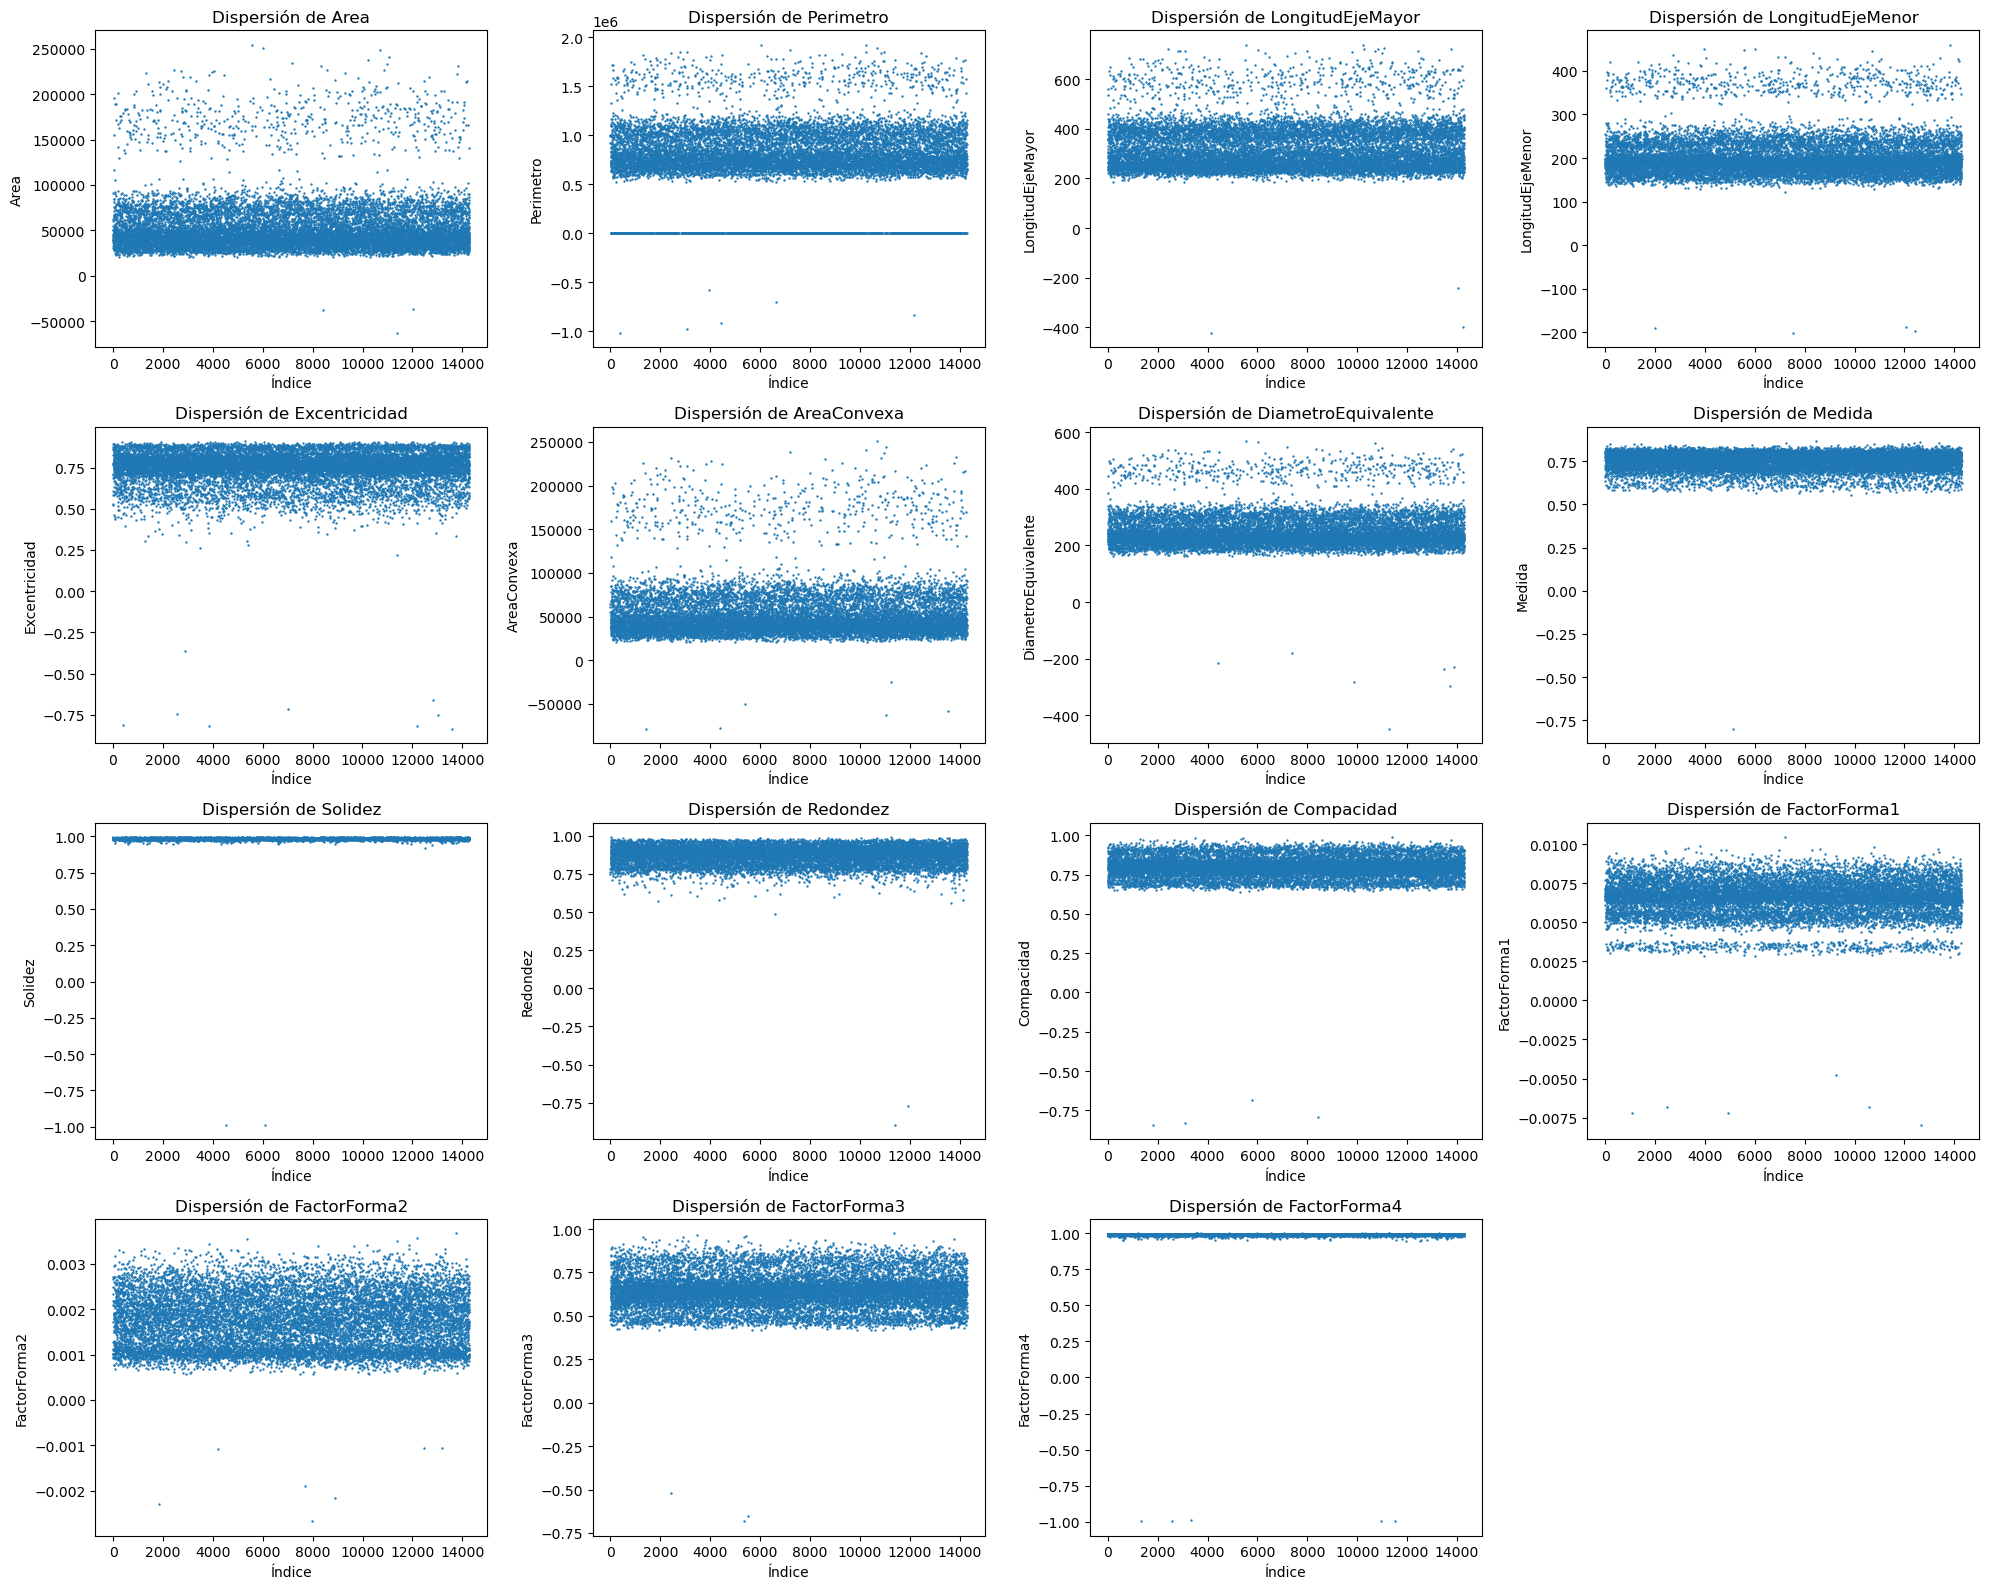

In [4]:
import math

columnas_por_fila = 4
filas = math.ceil(len(numericas) / columnas_por_fila)
fig, ejes = plt.subplots(filas, columnas_por_fila, figsize=(columnas_por_fila * 5, filas * 4))
ejes = ejes.flatten()

for eje, columna in zip(ejes, numericas):
    eje.scatter(df.index, df[columna], s=0.5)
    eje.set_xlabel("Índice")
    eje.set_ylabel(columna)
    eje.set_title(f"Dispersión de {columna}")

for eje in ejes[len(numericas):]:
    eje.set_visible(False)

plt.tight_layout()
plt.show()


##### 2.1.2 Histogramas

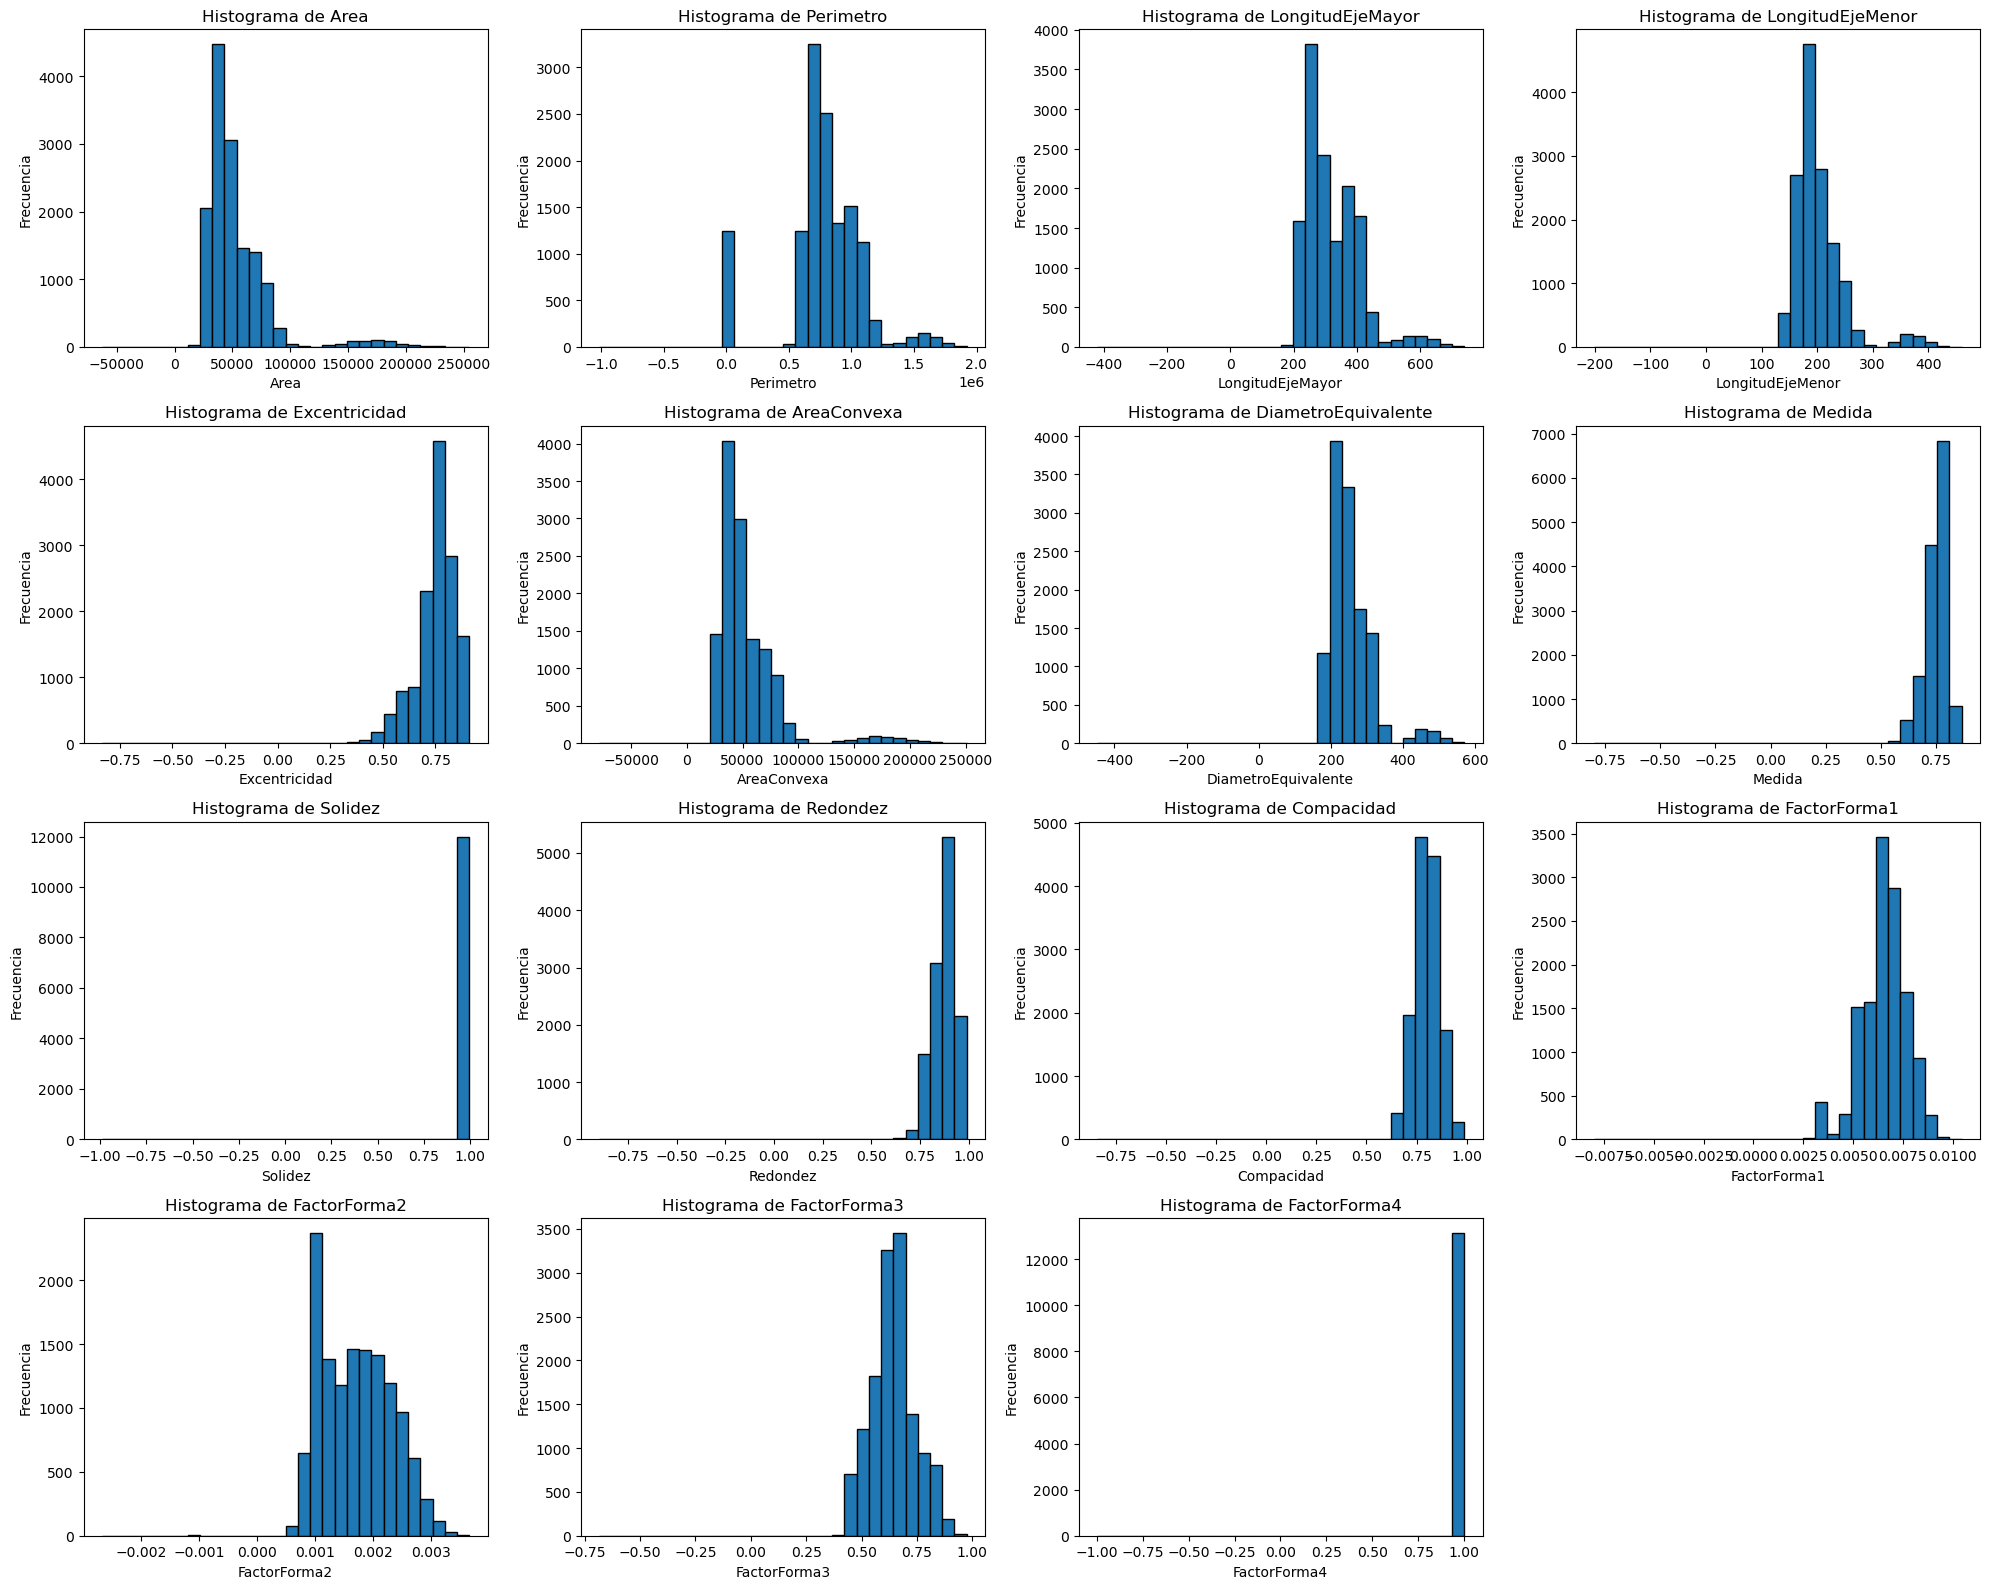

In [5]:
import math

columnas_por_fila = 4
filas_histo = math.ceil(len(numericas) / columnas_por_fila)

fig, axes_hist = plt.subplots(filas_histo, columnas_por_fila, figsize=(columnas_por_fila * 5, filas_histo * 4))
axes_hist = axes_hist.flatten()

for ax, col in zip(axes_hist, numericas):
    datos_col = df[col].dropna()
    ax.hist(datos_col, bins=30, edgecolor="black")
    ax.set_title(f"Histograma de {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Frecuencia")

for ax in axes_hist[len(numericas):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


##### 2.1.3 Boxplots

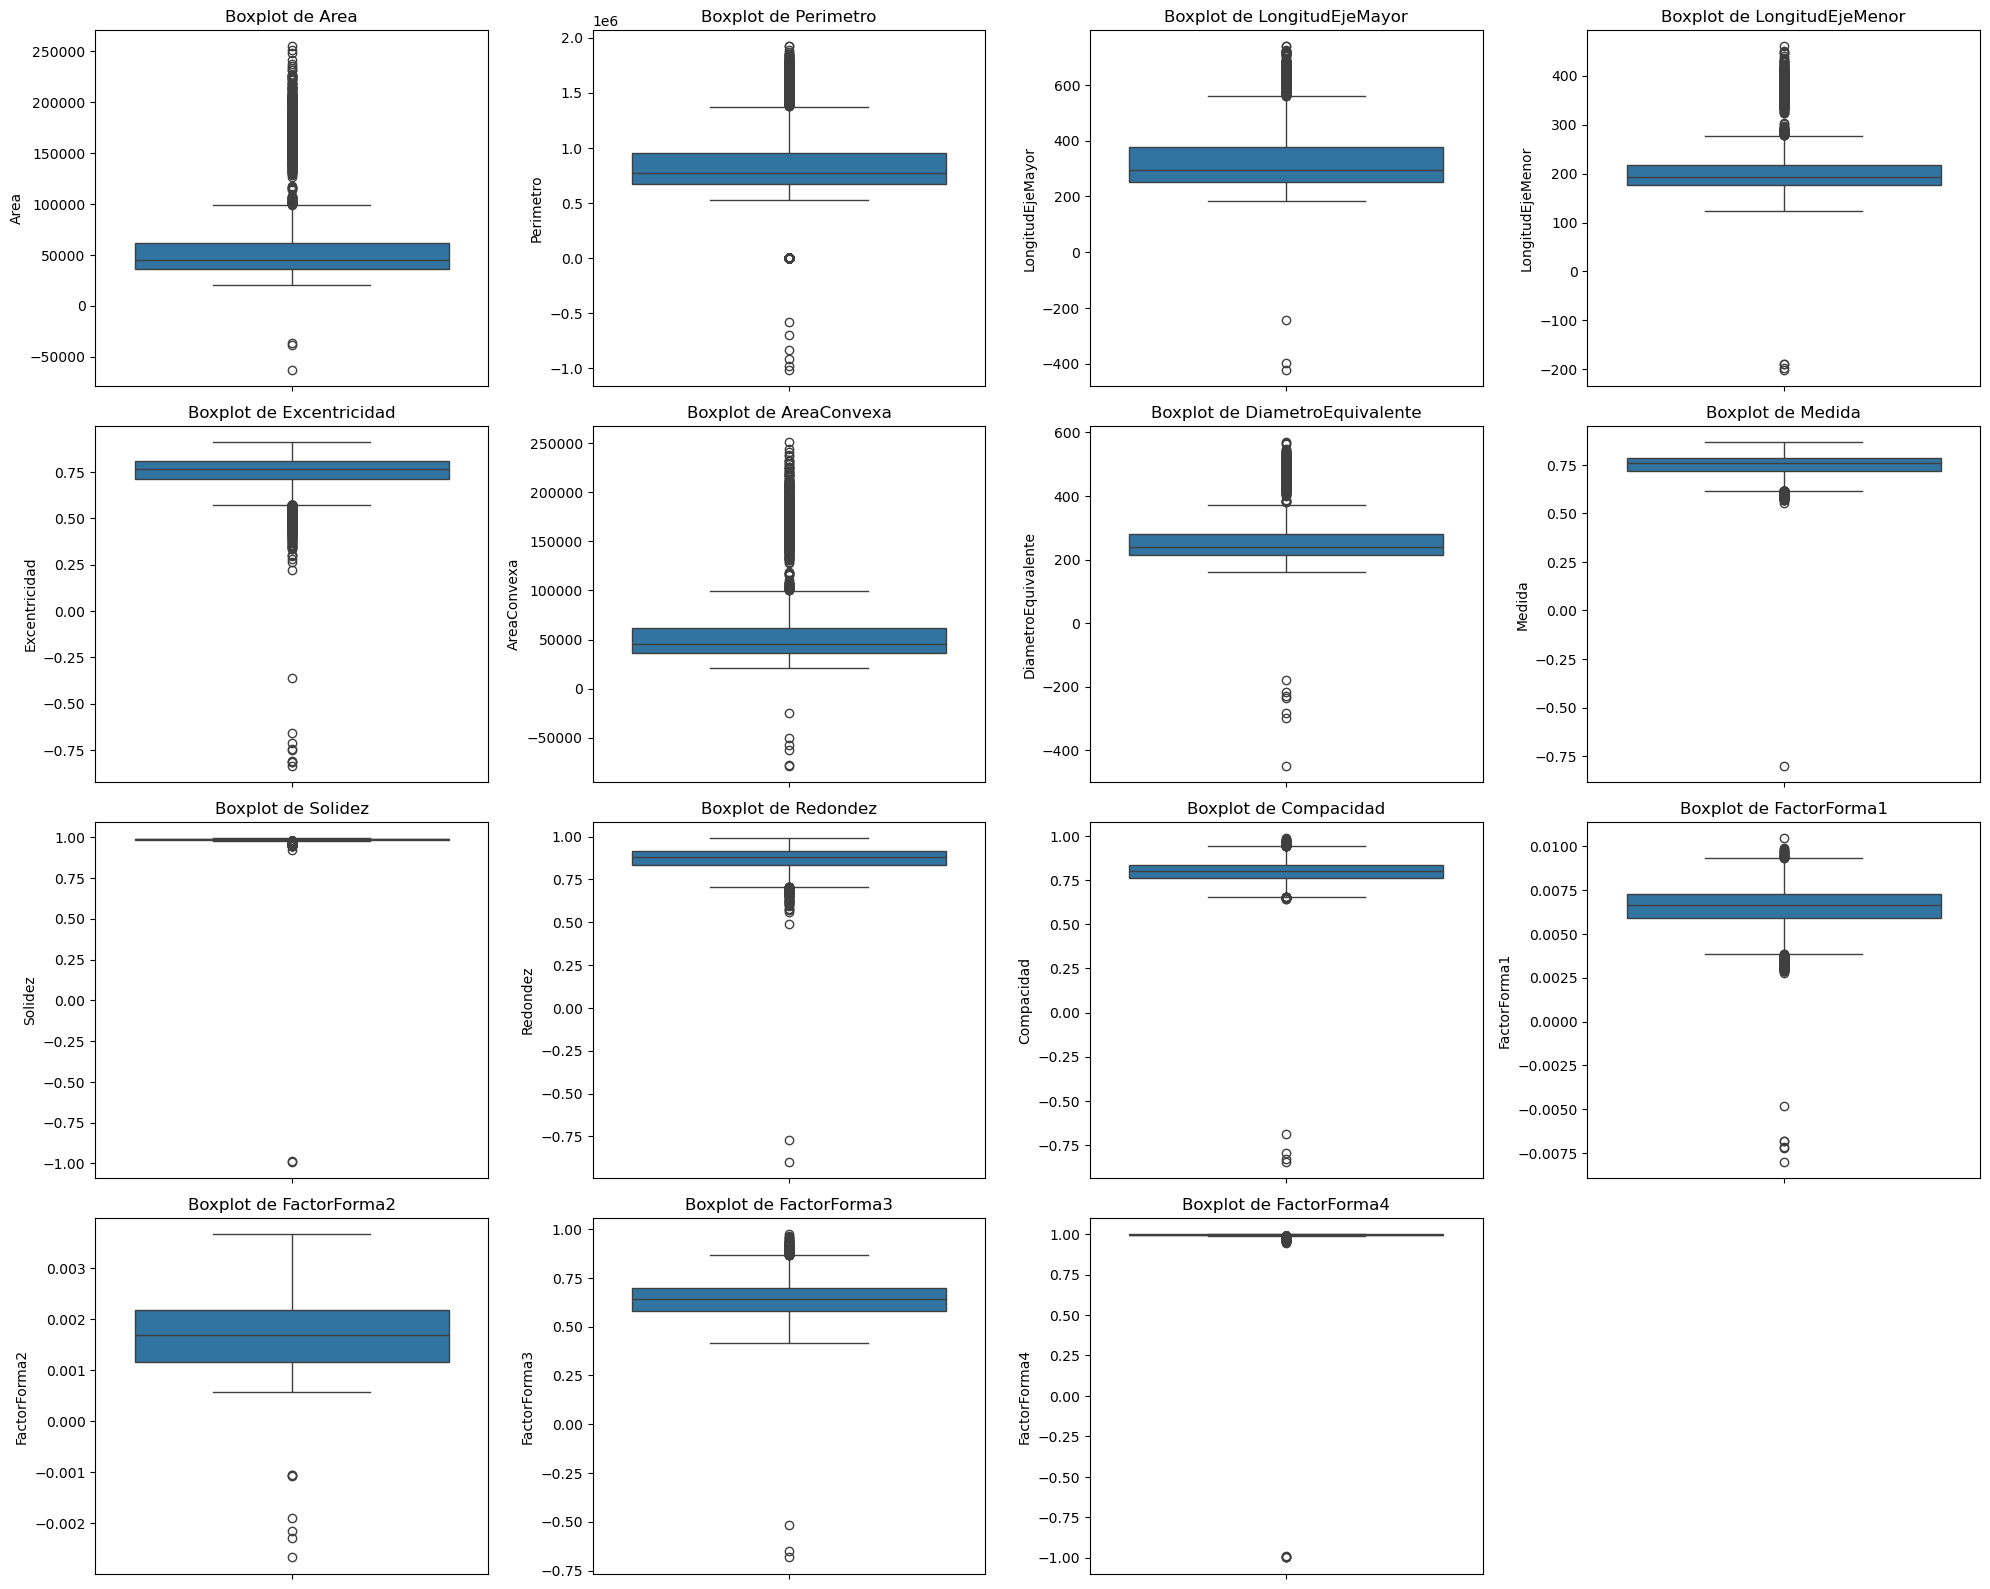

In [6]:
columnas_por_fila = 4
filas_boxplot = math.ceil(len(numericas) / columnas_por_fila)

fig, axes_box = plt.subplots(filas_boxplot, columnas_por_fila, figsize=(columnas_por_fila * 5, filas_boxplot * 4))
axes_box = axes_box.flatten()

for ax, col in zip(axes_box, numericas):
    sns.boxplot(y=df[col], ax=ax)
    ax.set_title(f"Boxplot de {col}")
    ax.set_ylabel(col)

for ax in axes_box[len(numericas):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


#### 2.1.4 Conclusiones iniciales sobre las variables numéricas

Del análisis de las gráficas de dispersión, histogramas y boxplots se destacan las siguientes observaciones:

1. Escalas muy diferentes entre variables:  
   Algunas variables como Área, Perímetro, LongitudEjeMayor y ÁreaConvexa alcanzan valores en el orden de cientos de miles, mientras que otras como Solidez, Redondez, Compacidad, Medida y los Factores de forma están acotadas entre 0 y 1. Esto confirma la necesidad de aplicar escalado o normalización antes de entrenar los algoritmos de agrupación.

2. Distribuciones asimétricas y sesgos:  
   Varias variables presentan distribuciones sesgadas hacia la derecha, por ejemplo Área, Perímetro y DiametroEquivalente. En el caso de las variables acotadas, como Solidez y Redondez, la mayoría de valores se concentran en el extremo superior. Estos patrones de distribución podrían requerir transformaciones (como logaritmos) para estabilizar la varianza.

3. Valores atípicos (outliers):  
   Los boxplots muestran una gran cantidad de valores extremos en casi todas las variables. Incluso se observan registros negativos en variables que conceptualmente deberían ser positivas, como Área, Perímetro y DiametroEquivalente. Estos casos deben ser evaluados para decidir si se eliminan, se imputan o se mantienen.

4. Variables con poca variabilidad:  
   Algunas variables como Solidez y FactorForma4 están muy concentradas en valores cercanos a 1, lo que limita su poder discriminante para diferenciar grupos. Es posible que tengan poca relevancia para el clustering.

5. Implicaciones para el modelado: 
   - Algoritmos como K-Means y Gaussian Mixture son sensibles a las diferencias de escala y a los outliers, por lo que se debe asegurar un preprocesamiento cuidadoso.  
   - Algoritmos más robustos como DBSCAN o Agglomerative Clustering podrían ser útiles para manejar distribuciones irregulares y valores extremos.  
   - Será necesario complementar este análisis con una matriz de correlación para evitar redundancia de variables antes de modelar.

En conclusión, los datos presentan heterogeneidad en escalas, distribuciones sesgadas y valores atípicos que deberán ser tratados en la etapa de preparación, con el fin de garantizar resultados consistentes en los algoritmos de agrupación.


## 2.2 Análisis del perfilamiento

En esta sección se revisa la calidad del conjunto de datos desde varios ángulos: filas duplicadas, valores nulos, estadísticas descriptivas, correlaciones entre variables numéricas y verificación de rangos plausibles según el diccionario. Este perfilamiento permite detectar problemas antes de la preparación y el modelado.


### 2.2.1 Análisis de filas duplicadas


En esta celda se identifican registros duplicados de dos formas. Primero, se buscan filas idénticas en todas las columnas. Segundo, se verifica si existen códigos ID repetidos, asumiendo que el identificador debe ser único por grano. Si se encuentran duplicados, se listan ejemplos para su inspección.


In [7]:
duplicadas_df = df[df.duplicated(keep=False)]
n_duplicadas = df.duplicated().sum()

print("Cantidad de filas duplicadas:", n_duplicadas)
display(duplicadas_df.head(5))

if "ID" in df.columns:
    dup_por_id = df[df["ID"].duplicated(keep=False)].sort_values("ID")
    n_ids_dup = df["ID"].duplicated().sum()
    print("\nCantidad de IDs repetidos:", n_ids_dup)
    display(dup_por_id.head(5))


Cantidad de filas duplicadas: 461


,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MétodoSecado
16,G000100,33143,NaN,222.526309,189.737379,Redondeado,0.522480,33377.0,205.423899,0.769980,0.992989,0.990685,0.923144,0.006714,NaN,0.852195,NaN,Normal,NaN
20,G012961,36876,707667.0,261.019476,180.562424,Alargado,0.722129,37270.0,216.684059,0.716136,0.989428,0.925328,0.830145,0.007078,0.002074,0.689141,0.996216,Normal,Natural
30,G009056,45954,795062.0,294.820672,199.020609,Alargado,0.737766,46398.0,241.889334,0.780296,0.990431,0.913548,0.820463,0.006416,0.001793,0.673159,0.997189,Normal,Lavado
37,G000534,36568,691529.0,241.392193,193.119305,Redondeado,0.599969,36883.0,215.777255,0.789669,0.991459,0.960927,0.893887,0.006601,0.002600,0.799033,0.998763,Normal,Lavado
40,G011077,29081,636593.0,237.301527,156.431380,Alargado,0.751959,29481.0,192.424217,0.703680,0.986432,0.901769,0.810885,0.008160,0.002176,0.657534,0.997459,Normal,Natural



Cantidad de IDs repetidos: 680


,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MétodoSecado
7772,G000009,30685,635681.0,213.534145,183.157146,Redondeado,0.514081,31044.0,197.659696,0.771561,NaN,0.954240,0.925658,0.006959,0.003152,0.856844,0.998953,NaN,Lavado
824,G000009,30685,635681.0,213.534145,183.157146,Redondeado,0.514081,31044.0,197.659696,0.771561,NaN,0.954240,0.925658,0.006959,0.003152,0.856844,0.998953,NaN,Lavado
13306,G000036,31992,640338.0,212.887364,191.487254,Redondeado,0.436968,32258.0,NaN,0.774212,0.991754,0.980466,0.948038,0.006654,0.003316,0.898777,NaN,NaN,Lavado
1246,G000036,31992,640338.0,212.887364,191.487254,Redondeado,0.436968,32258.0,NaN,0.774212,0.991754,0.980466,0.948038,0.006654,0.003316,0.898777,NaN,NaN,Lavado
11738,G000048,32218,653595.0,222.756071,184.404684,Redondeado,0.560976,32566.0,202.536988,0.754432,0.989314,0.947744,0.909232,0.006914,0.002915,0.826703,0.998636,NaN,Lavado


Se encontraron 461 filas duplicadas en el dataset. Además, también se detectaron identificadores (ID) repetidos, lo que confirma que no todos los registros representan granos únicos. 
Para la preparación será necesario decidir si se eliminan estos duplicados para evitar sesgos en el análisis de agrupación, ya que podrían inflar artificialmente ciertos clusters.

### 2.2.2 Valores nulos


En esta celda se cuantifica la presencia de valores nulos por columna y se visualiza su porcentaje. Esta información ayuda a decidir estrategias de imputación o eliminación en la fase de preparación, considerando el impacto de cada variable en el análisis.


,n_nulos,%_nulos
DefectoVisible,2935,20.54
Solidez,2306,16.14
Redondez,2063,14.44
DiametroEquivalente,1923,13.46
AreaConvexa,1423,9.96
Perimetro,1237,8.66
FactorForma4,1159,8.11
FactorForma1,1119,7.83
FactorForma2,1106,7.74
Compacidad,650,4.55


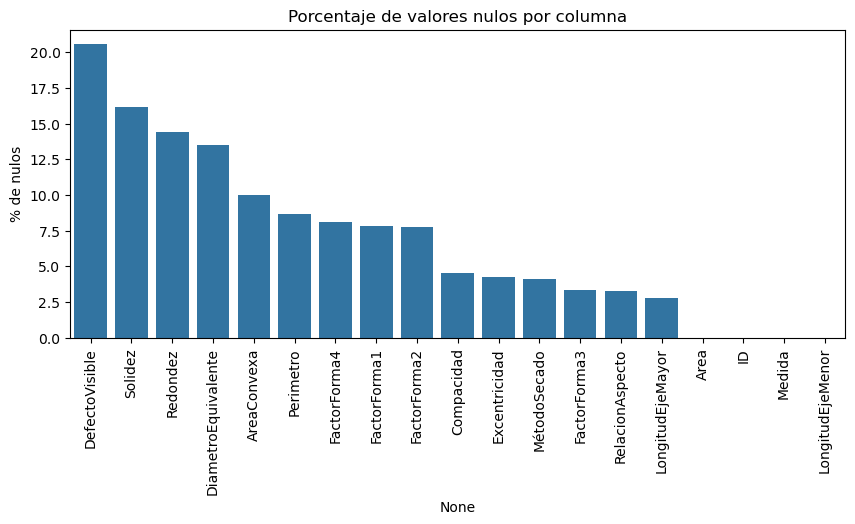

In [8]:
# Conteo y porcentaje de nulos por columna
nul_count = df.isna().sum().sort_values(ascending=False)
nul_pct = (df.isna().mean().sort_values(ascending=False) * 100).round(2)
nulos = pd.concat([nul_count, nul_pct], axis=1)
nulos.columns = ["n_nulos", "%_nulos"]
display(nulos)

# Visualización rápida de nulos por columna
plt.figure(figsize=(10, 4))
sns.barplot(x=nulos.index, y=nulos["%_nulos"])
plt.xticks(rotation=90)
plt.ylabel("% de nulos")
plt.title("Porcentaje de valores nulos por columna")
plt.show()


En cuanto a los valores nulos, se observó que varias variables presentan porcentajes considerables de ausencia de información. DefectoVisible es la más afectada con alrededor del 20 por ciento de registros sin valor, mientras que Solidez, Redondez y DiametroEquivalente superan el 13 por ciento. Otras variables geométricas como Área, LongitudEjeMayor y LongitudEjeMenor casi no presentan datos faltantes. Esta situación implica que deben adoptarse distintas estrategias de tratamiento: en variables categóricas como DefectoVisible puede ser útil asignar la categoría “Desconocido”, y en las variables numéricas con porcentajes intermedios de nulos conviene emplear técnicas de imputación como la media, la mediana o métodos más robustos. Por su parte, las variables sin datos faltantes no requieren ajustes adicionales.

### 2.2.3 Estadísticas descriptivas de variables numéricas


En esta celda se resumen medidas descriptivas por variable numérica, incluyendo percentiles, medias y dispersiones. También se reportan el sesgo y la curtosis para evaluar asimetrías y colas pesadas, lo que orienta decisiones sobre transformaciones y escalado.


In [9]:
desc = df[numericas].describe().T
display(desc)

extra = pd.DataFrame({
    "skew": df[numericas].skew(numeric_only=True),
    "kurtosis": df[numericas].kurt(numeric_only=True)
}).round(3)
display(extra)


,count,mean,std,min,25%,50%,75%,max
Area,14291.0,53055.408999,29396.080372,-6.271600e+04,36338.000000,44660.000000,61311.000000,2.546160e+05
Perimetro,13054.0,772986.954791,326649.281155,-1.012143e+06,676860.750000,772034.500000,955409.750000,1.921685e+06
LongitudEjeMayor,13890.0,319.985592,86.378452,-4.214447e+02,253.319858,296.682345,376.548109,7.388602e+02
LongitudEjeMenor,14291.0,202.178613,45.494541,-2.008387e+02,175.881052,192.437870,216.847844,4.601985e+02
Excentricidad,13687.0,0.749977,0.099438,-8.350038e-01,0.715144,0.764392,0.810441,9.114230e-01
AreaConvexa,12868.0,53575.397809,29566.387814,-7.842300e+04,36720.000000,45107.500000,62109.250000,2.510820e+05
DiametroEquivalente,12368.0,253.001741,60.542330,-4.484026e+02,215.302463,238.579492,279.672481,5.693744e+02
Medida,14291.0,0.749844,0.050774,-7.987057e-01,0.718767,0.760232,0.786942,8.661946e-01
Solidez,11985.0,0.986774,0.025947,-9.890416e-01,0.985597,0.988279,0.989991,9.943782e-01
Redondez,12228.0,0.873080,0.063237,-8.968612e-01,0.832824,0.883353,0.916803,9.906854e-01


,skew,kurtosis
Area,2.933,10.732
Perimetro,-0.574,2.011
LongitudEjeMayor,1.232,3.272
LongitudEjeMenor,1.989,7.869
Excentricidad,-3.001,33.344
AreaConvexa,2.893,10.778
DiametroEquivalente,1.450,8.252
Medida,-2.797,60.768
Solidez,-73.625,5601.860
Redondez,-3.753,87.443


Las estadísticas muestran que algunas variables como Área, Perímetro, LongitudEjeMayor y ÁreaConvexa tienen valores negativos, lo cual no es consistente con su definición geométrica y sugiere la existencia de errores de registro o problemas en la extracción de características. Además, varias variables presentan rangos muy amplios y desviaciones estándar elevadas, lo que confirma la heterogeneidad en las escalas del dataset. Variables como Solidez y FactorForma4 se concentran en valores muy altos cercanos a 1, lo que implica baja variabilidad y poca capacidad discriminante entre observaciones.

El análisis de sesgo y curtosis indica que muchas variables tienen distribuciones fuertemente asimétricas y con colas pesadas. Por ejemplo, Área y ÁreaConvexa presentan un sesgo positivo con curtosis elevada, lo que refleja la presencia de colas largas hacia valores altos. En contraste, variables como Solidez y FactorForma4 muestran sesgos y curtosis extremadamente altos debido a su concentración en un rango muy reducido. Estas características sugieren la necesidad de transformaciones y del uso de escaladores robustos para que los algoritmos de agrupación no se vean dominados por valores extremos.

### 2.2.4 Correlación entre variables numéricas


En esta celda se calcula y se grafica la matriz de correlación de Pearson para las variables numéricas. Luego se listan los pares de variables con mayor correlación absoluta. Esta revisión permite identificar redundancias que podrían simplificarse antes del modelado o tenerse en cuenta al interpretar los clusters.


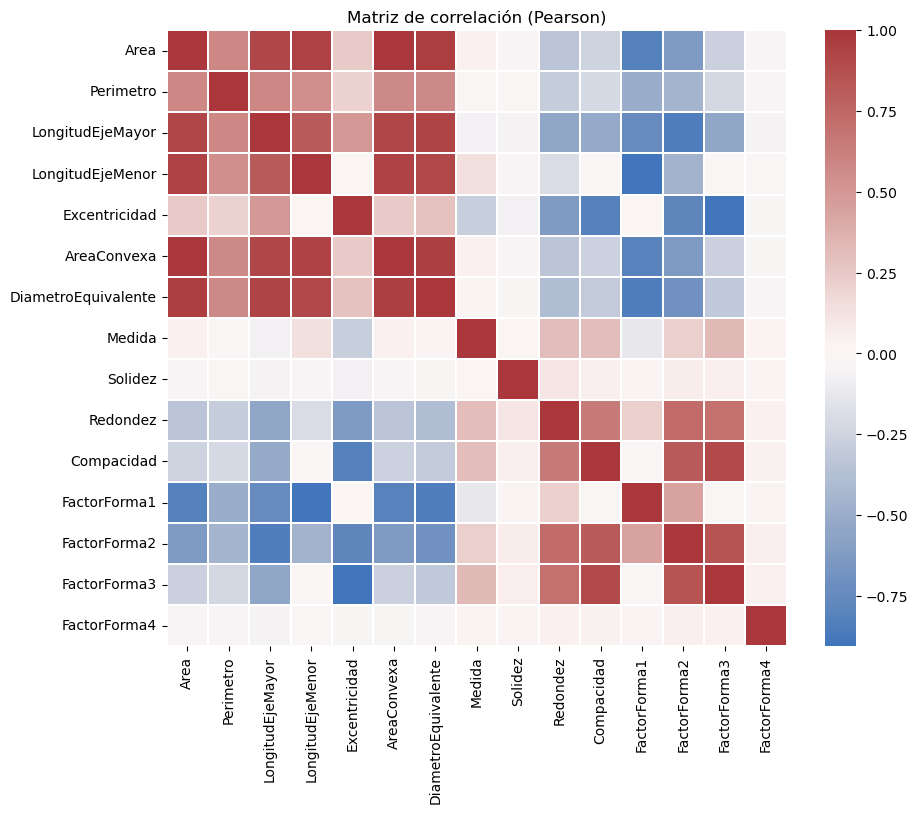

,var_1,var_2,corr_abs
0,Area,AreaConvexa,0.994689
1,Area,DiametroEquivalente,0.958933
2,AreaConvexa,DiametroEquivalente,0.952511
3,Area,LongitudEjeMenor,0.940869
4,LongitudEjeMenor,AreaConvexa,0.935487
5,LongitudEjeMayor,DiametroEquivalente,0.931813
6,Area,LongitudEjeMayor,0.924025
7,LongitudEjeMayor,AreaConvexa,0.920834
8,LongitudEjeMenor,DiametroEquivalente,0.913890
9,LongitudEjeMenor,FactorForma1,0.905972


In [10]:
corr = df[numericas].corr(method="pearson")
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="vlag", center=0, linewidths=.25)
plt.title("Matriz de correlación (Pearson)")
plt.show()

corr_abs = corr.abs()
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))
top_pairs = (
    upper.stack()
         .sort_values(ascending=False)
         .head(15)
         .rename("corr_abs")
         .reset_index()
         .rename(columns={"level_0": "var_1", "level_1": "var_2"})
)
display(top_pairs)


## 2.3 Análisis de calidad

En esta sección se evalúa la calidad de los datos considerando cuatro dimensiones principales:

- Completitud: se revisa el grado en que las variables presentan valores faltantes o ausentes.  
- Unicidad: se analiza la existencia de registros o identificadores duplicados que puedan afectar la confiabilidad del dataset.  
- Consistencia: se identifican posibles discrepancias en los valores que indiquen errores de captura o cálculo.  
- Validez: se comprueba que los valores respeten los formatos y rangos esperados de acuerdo con la definición de cada variable.  

El análisis de calidad permite determinar qué tan confiables y útiles son los datos para el proceso de agrupación.


### 2.3.1 Completitud


El análisis de completitud muestra la cantidad y el porcentaje de valores nulos por columna. En este dataset se observa que variables como DefectoVisible y Solidez presentan porcentajes elevados de valores ausentes, mientras que otras como Área o LongitudEjeMayor prácticamente no tienen faltantes. Esto sugiere que será necesario aplicar estrategias de imputación diferenciadas según la naturaleza de cada variable.


In [11]:
# Conteo y porcentaje de valores nulos por columna
faltantes = df.isnull().sum()
porcentaje_faltante = 100 * df.isnull().sum() / len(df)

completitud = pd.DataFrame({
    "Valores_faltantes": faltantes,
    "Porcentaje": porcentaje_faltante.round(2)
}).sort_values(by="Porcentaje", ascending=False)

display(completitud)


,Valores_faltantes,Porcentaje
DefectoVisible,2935,20.54
Solidez,2306,16.14
Redondez,2063,14.44
DiametroEquivalente,1923,13.46
AreaConvexa,1423,9.96
Perimetro,1237,8.66
FactorForma4,1159,8.11
FactorForma1,1119,7.83
FactorForma2,1106,7.74
Compacidad,650,4.55


### 2.3.2 Unicidad


El análisis de unicidad confirma que existen registros con identificadores repetidos. Esto significa que no todos los granos tienen un código único en el dataset. Para evitar sesgos en los resultados de agrupación será necesario eliminar los duplicados o decidir una forma de consolidarlos en la etapa de preparación.


In [12]:
ids_duplicados = df["ID"].duplicated().sum()
print("Cantidad de IDs duplicados:", ids_duplicados)


Cantidad de IDs duplicados: 680


In [13]:
import re

id_col = None
for c in df.columns:
    if re.fullmatch(r"\s*id\s*", str(c), flags=re.IGNORECASE):
        id_col = c
        break

if id_col is not None and id_col != "ID":
    df = df.rename(columns={id_col: "ID"})
    id_col = "ID"

if id_col is None:
    print("No se encontró una columna equivalente a 'ID'. Revisa los encabezados impresos en la celda anterior.")
else:
    ids_duplicados = df[id_col].duplicated().sum()
    print("Cantidad de IDs duplicados:", ids_duplicados)

    dup_rows = df[df[id_col].duplicated(keep=False)].sort_values(id_col).head(10)
    display(dup_rows)


Cantidad de IDs duplicados: 680


,ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MétodoSecado
7772,G000009,30685,635681.0,213.534145,183.157146,Redondeado,0.514081,31044.0,197.659696,0.771561,NaN,0.954240,0.925658,0.006959,0.003152,0.856844,0.998953,NaN,Lavado
824,G000009,30685,635681.0,213.534145,183.157146,Redondeado,0.514081,31044.0,197.659696,0.771561,NaN,0.954240,0.925658,0.006959,0.003152,0.856844,0.998953,NaN,Lavado
13306,G000036,31992,640338.0,212.887364,191.487254,Redondeado,0.436968,32258.0,NaN,0.774212,0.991754,0.980466,0.948038,0.006654,0.003316,0.898777,NaN,NaN,Lavado
1246,G000036,31992,640338.0,212.887364,191.487254,Redondeado,0.436968,32258.0,NaN,0.774212,0.991754,0.980466,0.948038,0.006654,0.003316,0.898777,NaN,NaN,Lavado
11738,G000048,32218,653595.0,222.756071,184.404684,Redondeado,0.560976,32566.0,202.536988,0.754432,0.989314,0.947744,0.909232,0.006914,0.002915,0.826703,0.998636,NaN,Lavado
983,G000048,32218,653595.0,222.756071,184.404684,Redondeado,0.560976,32566.0,202.536988,0.754432,0.989314,0.947744,0.909232,0.006914,0.002915,0.826703,0.998636,NaN,Lavado
8611,G000064,32525,663914.0,225.077856,184.214734,Redondeado,0.574579,33000.0,203.499671,0.769058,NaN,0.927264,0.904130,0.006920,0.002852,0.817451,0.998781,Normal,Lavado
779,G000064,32525,663914.0,225.077856,184.214734,Redondeado,0.574579,33000.0,203.499671,0.769058,NaN,0.927264,0.904130,0.006920,0.002852,0.817451,0.998781,Normal,Lavado
10441,G000071,32713,660043.0,215.416321,193.486462,Redondeado,0.439592,33020.0,204.086955,0.799516,0.990703,0.943595,0.947407,0.006585,0.003273,0.897580,0.999312,Normal,Lavado
1125,G000071,32713,660043.0,215.416321,193.486462,Redondeado,0.439592,33020.0,204.086955,0.799516,0.990703,0.943595,0.947407,0.006585,0.003273,0.897580,0.999312,Normal,Lavado


### 2.3.3 Consistencia


En el análisis de consistencia se detectan valores que no cumplen con los rangos esperados según la definición de las variables. Por ejemplo, algunas medidas geométricas presentan valores negativos que no tienen sentido en este contexto, y ciertas proporciones exceden el rango entre 0 y 1. Estos casos deberán ser tratados en la preparación de datos para evitar distorsiones en los modelos de clustering.


In [14]:
# Variables que deberían estar en [0,1]
bounded = ["Excentricidad", "Solidez", "Redondez", "Compacidad", "Medida", "FactorForma4"]

violaciones_bounded = {}
for col in bounded:
    if col in df.columns:
        mask = (df[col] < 0) | (df[col] > 1)
        violaciones_bounded[col] = int(mask.sum())

violaciones_bounded = pd.Series(violaciones_bounded, name="fuera_[0,1]")
display(violaciones_bounded)

# Variables que no deberían tener valores negativos
non_negative = ["Area", "Perimetro", "LongitudEjeMayor", "LongitudEjeMenor", "AreaConvexa", "DiametroEquivalente"]

violaciones_neg = {}
for col in non_negative:
    if col in df.columns:
        mask = df[col] < 0
        violaciones_neg[col] = int(mask.sum())

violaciones_neg = pd.Series(violaciones_neg, name="negativos")
display(violaciones_neg)


Excentricidad    9
Solidez          2
Redondez         2
Compacidad       4
Medida           1
FactorForma4     5
Name: fuera_[0,1], dtype: int64

Area                   3
Perimetro              6
LongitudEjeMayor       3
LongitudEjeMenor       4
AreaConvexa            6
DiametroEquivalente    7
Name: negativos, dtype: int64

### 2.3.4 Validez


En el análisis de validez se revisan las variables categóricas para comprobar que los valores registrados correspondan con las categorías esperadas. Por ejemplo, RelacionAspecto debería contener etiquetas como Alargado o Redondeado, mientras que MétodoSecado incluye Lavado y Natural. Si se encuentran valores no esperados o inconsistentes, estos deberán ser corregidos o recategorizados.


In [15]:
for col in ["RelacionAspecto", "DefectoVisible", "MétodoSecado"]:
    if col in df.columns:
        print(f"\nColumna: {col}")
        print("Valores únicos:", df[col].dropna().unique())



Columna: RelacionAspecto
Valores únicos: ['alargado' 'Alargado' 'Redondeado' 'redondeado']

Columna: DefectoVisible
Valores únicos: ['Normal' 'normal']

Columna: MétodoSecado
Valores únicos: ['Lavado' 'Natural' 'lavado' 'natural' 'Honey' 'honey']


## 3. Preparación de los Datos

En esta etapa se busca limpiar y transformar el dataset para asegurar que la información sea confiable y esté lista para el modelado. Las principales acciones son:

- Verificar y eliminar valores nulos, en caso de existir.
- Identificar y tratar valores atípicos u outliers en variables numéricas revisadas en los diagramas de dispersión e histogramas

En esta celda se eliminan primero las filas idénticas en todas las columnas y luego los registros con identificadores repetidos, conservando la primera aparición. Esto asegura que cada grano tenga una única representación en el conjunto de datos.


### 3.1 Eliminación de duplicados


En esta celda se eliminan primero las filas idénticas en todas las columnas y luego los registros con identificadores repetidos, conservando la primera aparición. Esto asegura que cada grano tenga una única representación en el conjunto de datos.


In [16]:
# Eliminar filas duplicadas completas
print("Tamaño original:", df.shape)
df_prep = df.drop_duplicates()
print("Después de eliminar duplicados:", df_prep.shape)

# Verificar duplicados por ID
if "ID" in df_prep.columns:
    df_prep = df_prep.drop_duplicates(subset=["ID"], keep="first")
    print("Después de eliminar IDs duplicados:", df_prep.shape)


Tamaño original: (14291, 19)
Después de eliminar duplicados: (13830, 19)
Después de eliminar IDs duplicados: (13611, 19)


### 3.2 Eliminación de registros inconsistentes


En esta celda se eliminan los registros que no cumplen con los rangos definidos o que contradicen reglas geométricas básicas. Se descartan valores negativos en variables que deben ser no negativas, proporciones fuera del intervalo [0,1] y casos donde el Área supera el ÁreaConvexa o la LongitudEjeMenor es mayor a la LongitudEjeMayor.


In [17]:
mask_invalido = pd.Series(False, index=df_prep.index)

for col in ["Excentricidad", "Solidez", "Redondez", "Compacidad", "Medida", "FactorForma4"]:
    if col in df_prep.columns:
        mask_invalido |= (df_prep[col] < 0) | (df_prep[col] > 1)

for col in ["Area", "Perimetro", "LongitudEjeMayor", "LongitudEjeMenor", "AreaConvexa", "DiametroEquivalente",
            "FactorForma1", "FactorForma2", "FactorForma3"]:
    if col in df_prep.columns:
        mask_invalido |= (df_prep[col] < 0)

if {"Area", "AreaConvexa"}.issubset(df_prep.columns):
    mask_invalido |= df_prep["Area"] > df_prep["AreaConvexa"]

if {"LongitudEjeMenor", "LongitudEjeMayor"}.issubset(df_prep.columns):
    mask_invalido |= df_prep["LongitudEjeMenor"] > df_prep["LongitudEjeMayor"]

print("Registros originales:", df.shape[0])
print("Registros luego de eliminar inconsistentes:", df_prep[~mask_invalido].shape[0])

df_prep = df_prep[~mask_invalido]


Registros originales: 14291
Registros luego de eliminar inconsistentes: 13548


### 3.3 Imputación de valores nulos

En esta sección se imputan los valores faltantes para conservar la mayor cantidad posible de observaciones.  
- Para variables numéricas se utilizará la mediana, que es robusta frente a valores atípicos.  
- Para variables categóricas se asignará la categoría "Desconocido".  


In [18]:
from sklearn.impute import SimpleImputer


df_imp = df_prep.copy()

num_cols = df_imp.select_dtypes(include=["float64", "int64"]).columns
cat_cols = [c for c in ["RelacionAspecto", "DefectoVisible", "MétodoSecado"] if c in df_imp.columns]


imputer_num = SimpleImputer(strategy="median")
df_imp[num_cols] = imputer_num.fit_transform(df_imp[num_cols])


for col in cat_cols:
    df_imp[col] = df_imp[col].fillna("Desconocido")

print("Tamaño del dataset después de imputación:", df_imp.shape)
print("\nValores nulos restantes:")
print(df_imp.isna().sum().sort_values(ascending=False).head(10))


Tamaño del dataset después de imputación: (13548, 19)

Valores nulos restantes:
ID                     0
Area                   0
Perimetro              0
LongitudEjeMayor       0
LongitudEjeMenor       0
RelacionAspecto        0
Excentricidad          0
AreaConvexa            0
DiametroEquivalente    0
Medida                 0
dtype: int64


Con esta imputación se logró conservar los registros que antes se hubieran eliminado al aplicar dropna.  
- Las variables numéricas fueron completadas con la mediana de cada columna, evitando distorsión por outliers.  
- Las variables categóricas recibieron la categoría "Desconocido" para no perder información y permitir que en la validación cualitativa se interprete este grupo aparte.  
El resultado es un conjunto de datos sin valores faltantes, listo para el escalado y el modelado.


### 3.4 Eliminacion de outliers

En este paso se realiza la detección y eliminación de outliers extremos en las variables de tamaño, ya que estos valores atípicos distorsionan los centroides y la formación de clusters en el modelo KMeans. Para esto se aplica el método del rango intercuartílico (IQR), eliminando los registros que estén por debajo de Q1 - 1.5IQR o por encima de Q3 + 1.5IQR en las variables Área, Perímetro y Diámetro Equivalente. De esta forma se reduce el impacto de granos anómalos o errores de captura en el agrupamiento final

In [19]:
# Definir variables clave para detección de outliers
vars_outliers = ["Area", "Perimetro", "DiametroEquivalente"]

df_clean = df_imp.copy()  # trabajar sobre el dataset imputado

# Detección y eliminación de outliers con IQR
for col in vars_outliers:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    before = df_clean.shape[0]
    df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    after = df_clean.shape[0]
    
    print(f"Variable {col}: eliminados {before - after} outliers")

print(f"\nTamaño final del dataset después de limpieza de outliers: {df_clean.shape}")


Variable Area: eliminados 549 outliers
Variable Perimetro: eliminados 1157 outliers
Variable DiametroEquivalente: eliminados 191 outliers

Tamaño final del dataset después de limpieza de outliers: (11651, 19)


In [20]:
# Recorte por percentiles en variables de tamaño (ajusta si lo necesitas)
size_cols = ["Area", "Perimetro", "DiametroEquivalente"]
size_cols = [c for c in size_cols if c in df_clean.columns]

p_low, p_high = 0.01, 0.99   # 1% y 99%
prev = df_clean.shape[0]

for col in size_cols:
    lo, hi = df_clean[col].quantile([p_low, p_high]).tolist()
    mask_keep = (df_clean[col] >= lo) & (df_clean[col] <= hi)
    removed = (~mask_keep).sum()
    df_clean = df_clean[mask_keep]
    print(f"{col}: recorte [{p_low:.0%},{p_high:.0%}] → {removed} outliers eliminados")

print("Tamaño después de recorte por percentiles:", df_clean.shape)



Area: recorte [1%,99%] → 234 outliers eliminados
Perimetro: recorte [1%,99%] → 230 outliers eliminados
DiametroEquivalente: recorte [1%,99%] → 224 outliers eliminados
Tamaño después de recorte por percentiles: (10963, 19)


### 3.4 Selección de variables relevantes


In [21]:
vars_modelo = [
    'Area',
    'DiametroEquivalente',
    'Excentricidad',
    'Redondez',
    'Compacidad'
]

vars_modelo = [v for v in vars_modelo if v in df_clean.columns]

X = df_clean[vars_modelo].copy()
print("Variables seleccionadas:", vars_modelo)
print("Dimensiones de X:", X.shape)


Variables seleccionadas: ['Area', 'DiametroEquivalente', 'Excentricidad', 'Redondez', 'Compacidad']
Dimensiones de X: (10963, 5)


### Justificación de las variables seleccionadas para el modelo

Las variables escogidas corresponden a medidas geométricas y morfológicas extraídas de las imágenes de los granos de café. Estas son relevantes porque capturan la forma, el tamaño y la estructura de los granos, que son los atributos de mayor interés para SenecaféAlpes en su objetivo de caracterizar variedades y garantizar la uniformidad del producto.

- Área, Perímetro, LongitudEjeMayor, LongitudEjeMenor, ÁreaConvexa y DiámetroEquivalente representan el tamaño del grano y su extensión en diferentes dimensiones. Son esenciales para diferenciar granos grandes, pequeños o deformes.
- Excentricidad, Medida, Solidez, Redondez y Compacidad describen la forma y la proporción del grano. Estas medidas permiten identificar si los granos son más redondeados, alargados o presentan irregularidades.
- Los Factores de Forma 1 a 4 son índices derivados que integran relaciones entre medidas geométricas. Aportan información complementaria para capturar sutilezas en la estructura que no se aprecian solo con área o perímetro.

La decisión de excluir variables categóricas como RelacionAspecto, DefectoVisible y MétodoSecado se justifica porque los algoritmos de clustering utilizados se basan en distancias numéricas. Estas variables se conservarán únicamente para la interpretación cualitativa de los grupos una vez obtenidos los clusters.

En conclusión, las variables seleccionadas constituyen un conjunto robusto para el modelado porque combinan medidas de tamaño, proporción y forma, todas ellas directamente relacionadas con la calidad y la clasificación morfológica de los granos. Al ser estandarizadas y analizadas en conjunto, permiten descubrir patrones útiles para el control de calidad, la definición de mezclas y la trazabilidad del producto.


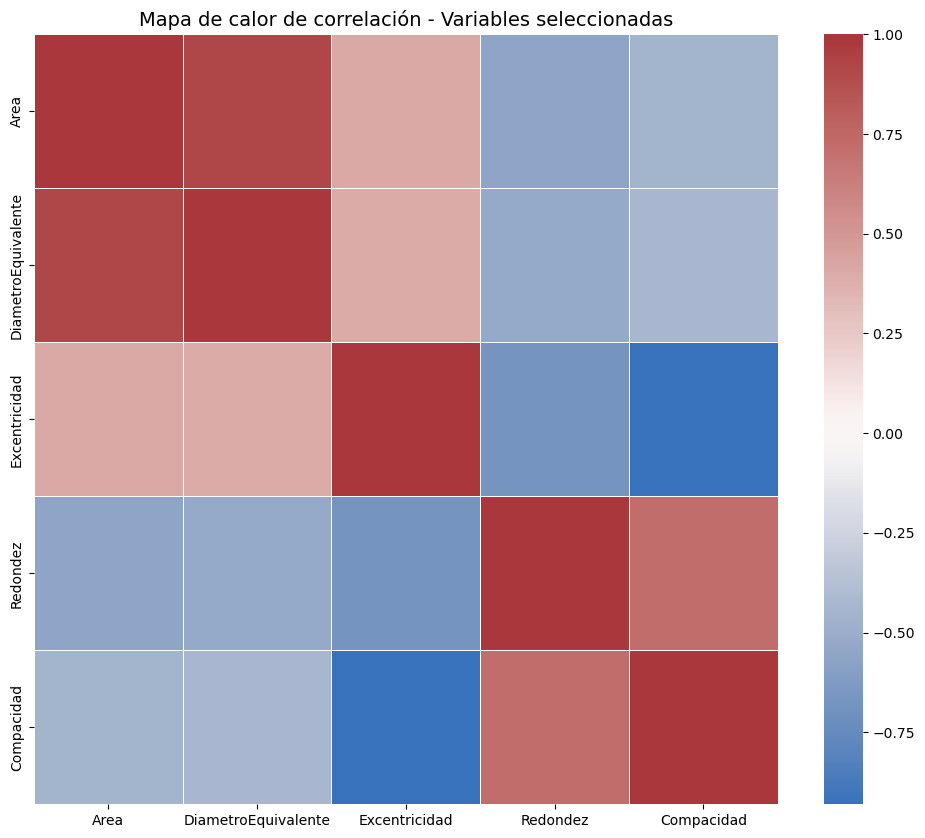

In [22]:
corr = X.corr(method="pearson")

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="vlag", center=0, annot=False, linewidths=.5)
plt.title("Mapa de calor de correlación - Variables seleccionadas", fontsize=14)
plt.show()


### 3.6 Exportación de los datos preparados

En esta celda se exporta el conjunto final de datos preparados, tanto completo como reducido a las variables seleccionadas para el clustering. De esta forma se conserva un respaldo que puede utilizarse en futuras etapas o reutilizarse sin necesidad de repetir todo el preprocesamiento.


In [29]:
df_clean.to_csv("SenecafeAlpes_preparado_completo.csv", index=False, encoding="utf-8-sig")
df_clean.to_excel("SenecafeAlpes_preparado_completo.xlsx", index=False)

X.to_csv("SenecafeAlpes_clustering_vars.csv", index=False, encoding="utf-8-sig")
X.to_excel("SenecafeAlpes_clustering_vars.xlsx", index=False)

print("Archivos exportados correctamente:")
print("- SenecafeAlpes_preparado_completo.csv / .xlsx")
print("- SenecafeAlpes_clustering_vars.csv / .xlsx")



Archivos exportados correctamente:
- SenecafeAlpes_preparado_completo.csv / .xlsx
- SenecafeAlpes_clustering_vars.csv / .xlsx


## 4. Entrenamiento de modelos

### 4.1 K-Means

El algoritmo K-Means es una técnica de clustering basada en la minimización de la distancia de cada punto al centroide más cercano. En este apartado se escalan previamente las variables seleccionadas para evitar que las diferencias de escala dominen el cálculo de distancias. Luego se entrenan modelos con distintos valores de K para determinar el número óptimo de clusters.


#### 4.1.1 Escalado de datos


En esta celda se aplicó el escalado estandarizado (media = 0, desviación estándar = 1) a todas las variables numéricas seleccionadas. Esto garantiza que todas las variables tengan el mismo peso en el cálculo de distancias, evitando que las de mayor rango (como Área o Perímetro) dominen el clustering.


In [30]:
from sklearn.preprocessing import StandardScaler

# Escalado de las variables seleccionadas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Dimensiones de X_scaled:", X_scaled.shape)


Dimensiones de X_scaled: (10963, 5)


#### 4.1.2 Determinación del número óptimo de clusters


En esta celda se evaluaron diferentes valores de K entre 2 y 10 mediante el método del codo, graficando la inercia (suma de distancias cuadradas a los centroides). El punto de inflexión en la curva sugiere un número óptimo de clusters que logra un buen balance entre complejidad y calidad de agrupación.


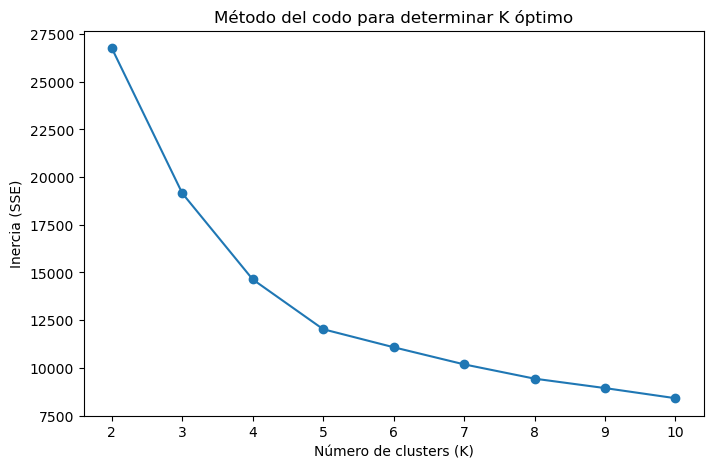

In [31]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k_values = range(2, 11)
inertia = []
sse = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_values, inertia, marker="o")
plt.title("Método del codo para determinar K óptimo")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inercia (SSE)")
plt.show()


La curva es bastante suave y decreciente, sin un punto de inflexión muy marcado. Esto ocurre cuando los datos no tienen grupos claramente separados, sino que forman más bien una distribución continua. En ese caso, K-Means va reduciendo la inercia de forma gradual a medida que aumentas el número de clusters, pero sin un codo.
Para decidir con más criterio, lo ideal es complementar con otra métrica como el coeficiente de silueta o Davies–Bouldin index. Estas dan un valor cuantitativo de qué tan compactos y separados están los clusters para cada K.

#### 4.1.4 Evaluación de K con Silhouette y Davies–Bouldin

Para complementar el método del codo se utilizan dos métricas adicionales:

- Coeficiente de Silueta: valores más altos indican clusters más compactos y mejor separados.  
- Índice de Davies–Bouldin: valores más bajos indican mejor desempeño de clustering.  


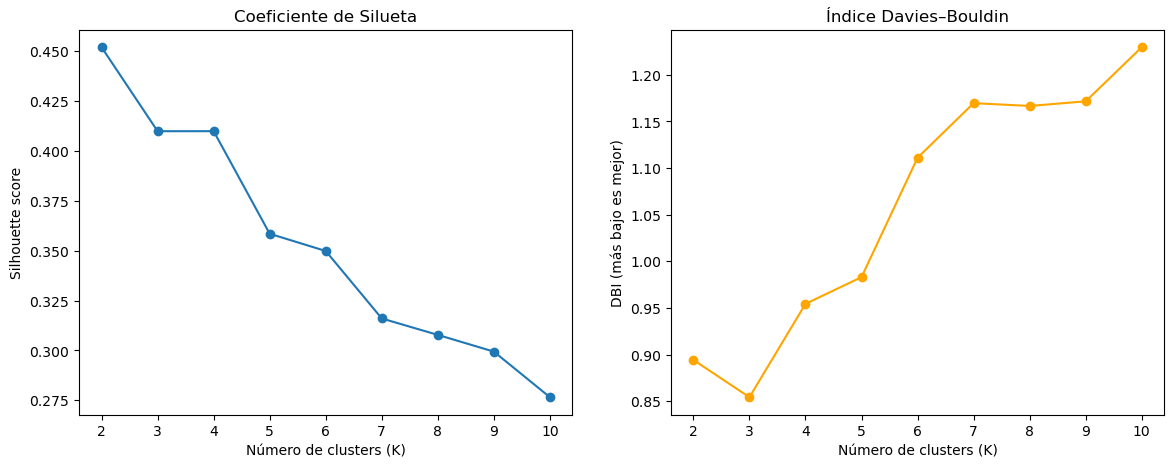

In [33]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

k_values = range(2, 11)
silhouette_scores = []
dbi_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    # Silhouette
    sil = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil)
    
    # DBI
    dbi = davies_bouldin_score(X_scaled, labels)
    dbi_scores.append(dbi)

# Graficar resultados
fig, axes = plt.subplots(1, 2, figsize=(14,5))

axes[0].plot(k_values, silhouette_scores, marker="o")
axes[0].set_title("Coeficiente de Silueta")
axes[0].set_xlabel("Número de clusters (K)")
axes[0].set_ylabel("Silhouette score")

axes[1].plot(k_values, dbi_scores, marker="o", color="orange")
axes[1].set_title("Índice Davies–Bouldin")
axes[1].set_xlabel("Número de clusters (K)")
axes[1].set_ylabel("DBI (más bajo es mejor)")

plt.show()


En el coeficiente de silueta, el valor mas alto se da en K=3 y k=4. Despues cae de manera pronunciada. Y en el indice Davies-Bouldin, el minimo esta en k=3. Esto nos indica el k optimo es 3.

#### 4.1.5 Entrenamiento del modelo con K óptimo

Se entrena K-Means con el número de clusters seleccionado. Se obtienen las etiquetas para cada observación y se agregan al DataFrame preparado para su posterior análisis e interpretación.


In [35]:
from sklearn.cluster import KMeans

k_optimo = 3  # elegido según codo + silueta + DBI

kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
labels_km = kmeans_final.fit_predict(X_scaled)

# Guardar etiquetas en el dataset preparado
df_clean["Cluster_KMeans"] = labels_km

print("Dimensiones de X_scaled:", X_scaled.shape)
print("Clusters aprendidos:", k_optimo)


Dimensiones de X_scaled: (10963, 5)
Clusters aprendidos: 3


In [37]:
import pandas as pd
import numpy as np

# Distribución de observaciones por cluster
conteo = df_clean["Cluster_KMeans"].value_counts().sort_index()
print("Distribución de observaciones por cluster:")
print(conteo)

# Centroides en escala original
centroides_orig = pd.DataFrame(
    scaler.inverse_transform(kmeans_final.cluster_centers_),
    columns=vars_modelo
)
centroides_orig.index = [f"Cluster_{i}" for i in range(k_optimo)]

print("\nCentroides en escala original:")
display(centroides_orig.round(4))


Distribución de observaciones por cluster:
Cluster_KMeans
0    5237
1    3876
2    1850
Name: count, dtype: int64

Centroides en escala original:


,Area,DiametroEquivalente,Excentricidad,Redondez,Compacidad
Cluster_0,38406.4142,222.8687,0.7529,0.8950,0.8085
Cluster_1,62325.6922,275.3385,0.8216,0.8229,0.7458
Cluster_2,38889.8521,223.9932,0.5838,0.9384,0.8959


En esta etapa se verificó el tamaño de cada grupo y se calcularon los centroides en la escala original de las variables. La distribución por cluster permite evaluar el balance de la partición y los centroides facilitan interpretar las características promedio de cada grupo en términos de tamaño y forma de los granos. Estos resultados se utilizarán en la siguiente sección para describir los clusters y validar su utilidad para el negocio.


#### 4.1.6 Visualización y análisis de los clusters

Se realizan distintas visualizaciones para comprender cómo se distribuyen los clusters en el espacio de variables, tanto mediante reducción de dimensionalidad (PCA) como con comparaciones bivariadas en variables de interés.


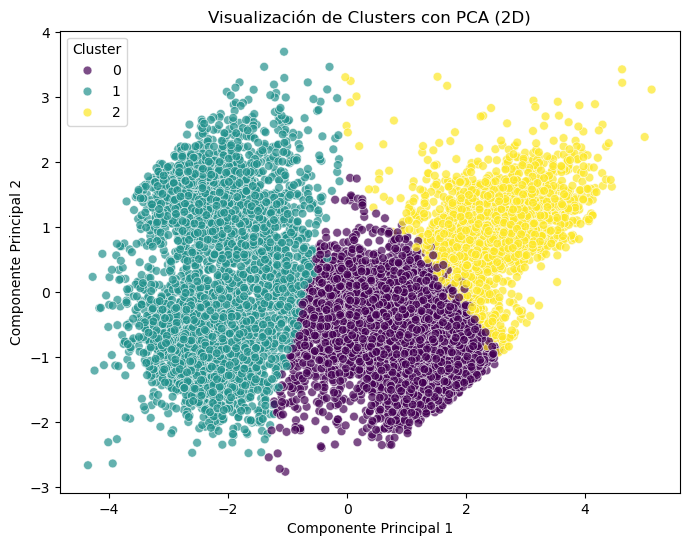

In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reducir a 2 dimensiones con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_clean["Cluster_KMeans"], palette="viridis", s=40, alpha=0.7)
plt.title("Visualización de Clusters con PCA (2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(title="Cluster")
plt.show()


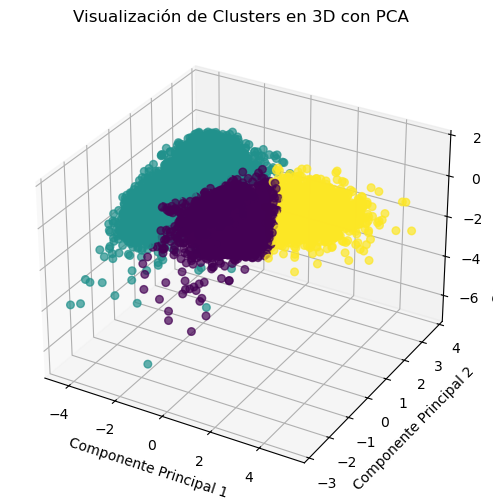

In [41]:
from mpl_toolkits.mplot3d import Axes3D

pca3d = PCA(n_components=3)
X_pca3 = pca3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca3[:,0], X_pca3[:,1], X_pca3[:,2],
           c=df_clean["Cluster_KMeans"], cmap="viridis", s=30, alpha=0.7)

ax.set_title("Visualización de Clusters en 3D con PCA")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
plt.show()


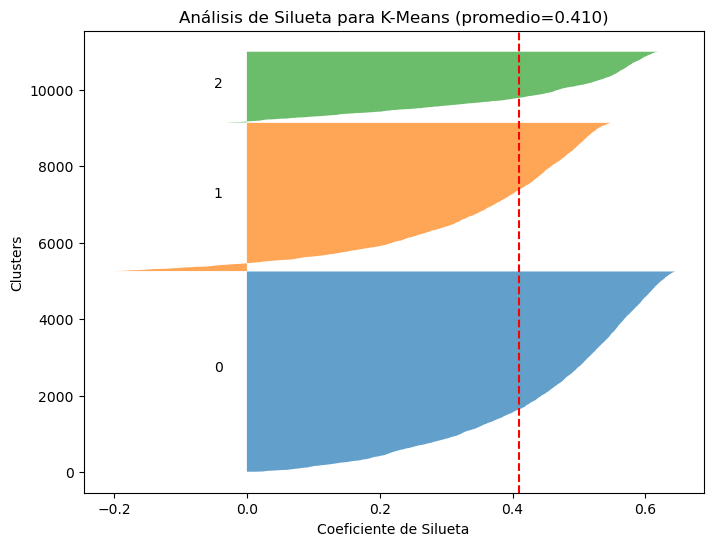

In [42]:
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

silhouette_vals = silhouette_samples(X_scaled, labels_km)
silhouette_avg = silhouette_score(X_scaled, labels_km)

plt.figure(figsize=(8,6))
y_lower = 10
for i in range(k_optimo):
    ith_cluster_silhouette_values = silhouette_vals[labels_km == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      alpha=0.7)
    plt.text(-0.05, y_lower + 0.5*size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title(f"Análisis de Silueta para K-Means (promedio={silhouette_avg:.3f})")
plt.xlabel("Coeficiente de Silueta")
plt.ylabel("Clusters")
plt.show()


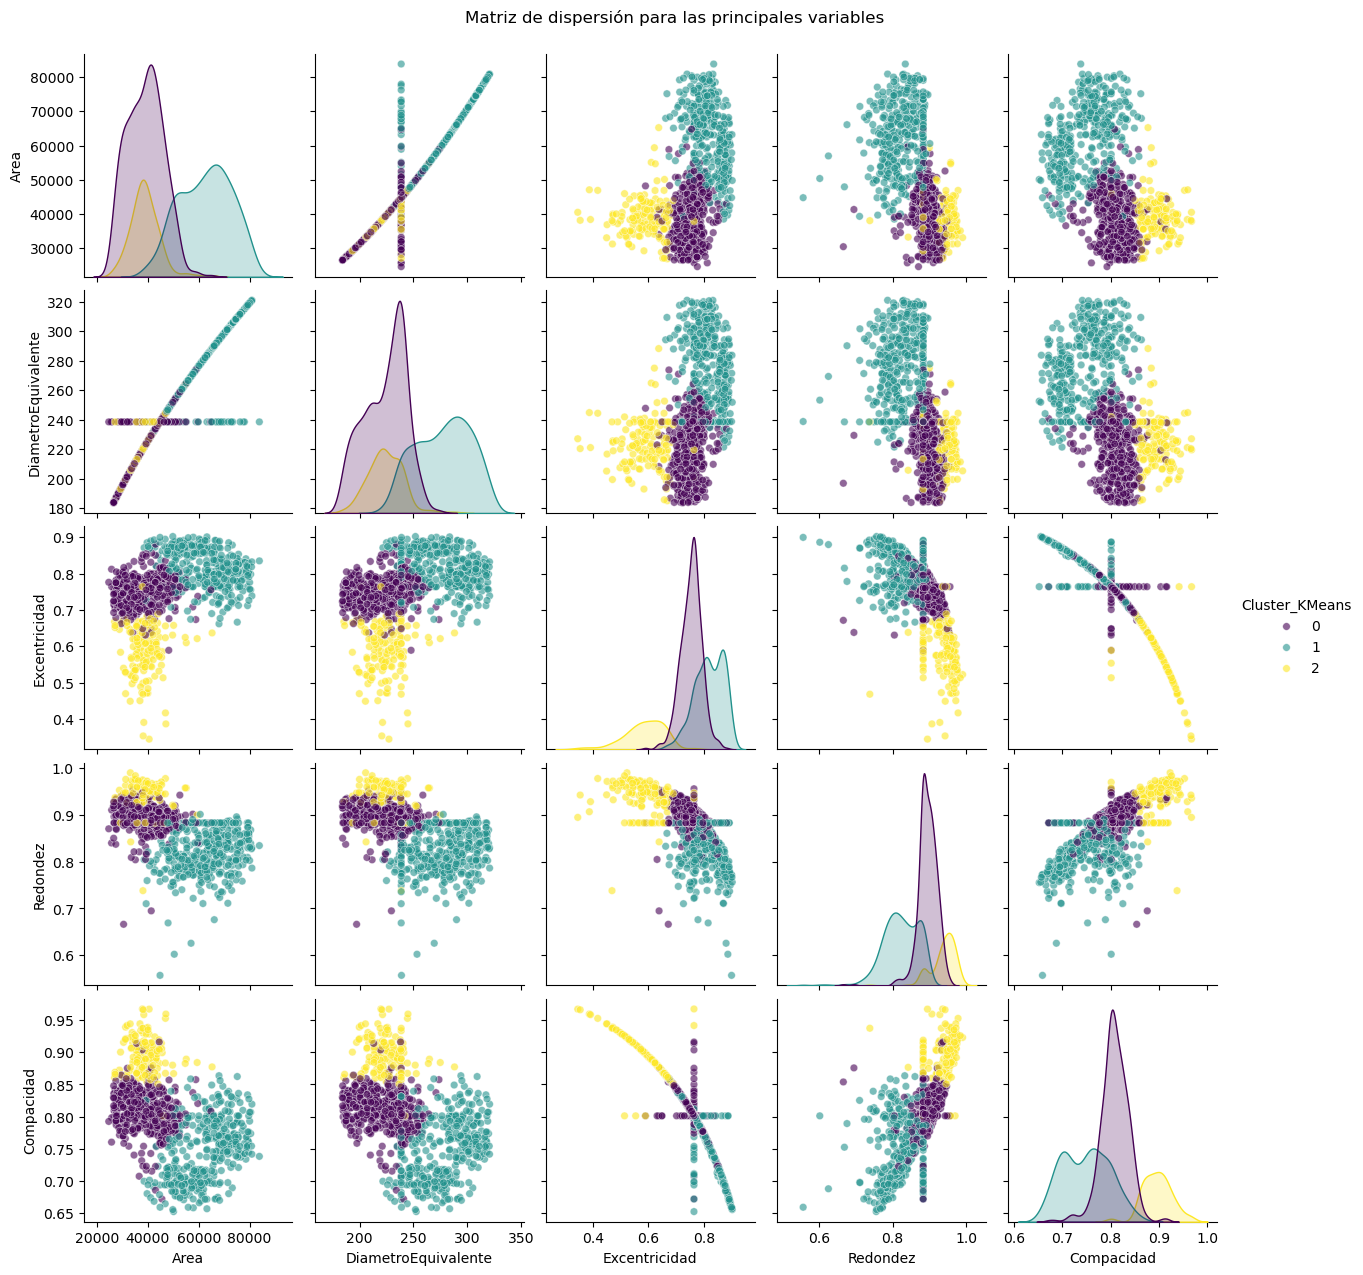

In [45]:
sns.pairplot(df_clean.sample(1000), vars=vars_modelo[:6], hue="Cluster_KMeans", palette="viridis", diag_kind="kde", plot_kws={"alpha":0.6, "s":30})
plt.suptitle("Matriz de dispersión para las principales variables", y=1.02)
plt.show()

En el proceso de clustering utilizando K-Means, se evaluaron diferentes valores de 
K mediante el coeficiente de silueta y el índice Davies-Bouldin. Ambos indicadores señalaron que el número óptimo de clusters se encuentra en 
K=3, ya que este punto logra un balance entre cohesión interna (menor dispersión dentro de cada grupo) y separación externa (mayor distancia entre clusters).

La visualización en dos dimensiones con PCA muestra una separación clara de los tres grupos, lo que evidencia que los clusters encontrados representan patrones diferenciados en los datos. Si bien existe cierta superposición entre puntos de frontera —lo cual es esperable en datos de alta dimensionalidad reducidos a dos componentes—, las agrupaciones principales resultan consistentes.

El análisis de las variables clave [Area, Diámetro Equivalente, Excentricidad, Redondez y Compacidad] respalda la validez de los clusters. Estas variables aportan una diferenciación notable: por ejemplo, un cluster está asociado a áreas y perímetros más grandes, mientras que otros se distinguen por una mayor compacidad o menor redondez. Las gráficas de dispersión y la matriz de pares confirman que cada cluster refleja un comportamiento distinto en estas dimensiones.

En conclusión, el modelo K-Means con K=3 logra capturar tres perfiles bien diferenciados en los datos, con una calidad de partición aceptable según las métricas empleadas. Esto sugiere que el preprocesamiento realizado permitió estabilizar el modelo y obtener clusters más interpretables.

### 4.2 DBSCAN

#### 4.2.1 Datos de entrada (reutilizando X_scaled)

In [51]:
import numpy as np
import pandas as pd

try:
    X_scaled
except NameError:
    # Fallback: recrear X_scaled exactamente como se hizo en k-means
    from sklearn.preprocessing import StandardScaler
    X = df_clean[vars_modelo].copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("[Aviso] X_scaled no estaba en memoria; se reconstruyó con StandardScaler sobre df_imp[vars_modelo].")

# DataFrame numérico alineado para perfilado posterior
df_num = df_clean[vars_modelo].reset_index(drop=True).copy()
print("Shape X_scaled:", X_scaled.shape, "| df_num:", df_num.shape)


Shape X_scaled: (10963, 5) | df_num: (10963, 5)


Se reutilizó la misma matriz escalada (X_scaled) empleada en K-Means, con 15 variables morfológicas y 13548 observaciones. La coherencia de dimensiones entre X_scaled y el DataFrame numérico garantiza comparabilidad entre modelos y un perfilado sin desalineaciones

#### 4.2.2 Curva k-distance (heurística para eps)

En esta sección construiremos la gráfica k-distance para orientar la elección del parámetro eps de DBSCAN. La idea es medir, para cada punto, la distancia a su k-ésimo vecino más cercano (usaremos un valor de k coherente con el número mínimo de vecinos que exigiremos en el algoritmo) y ordenar esas distancias de menor a mayor. Cuando la curva presenta un “codo”, ese quiebre señala el umbral a partir del cual los puntos dejan de tener vecindarios densos y comienzan a separarse con rapidez. Tomaremos ese rango alrededor del codo como candidatos iniciales para eps. Con esto evitamos escoger el valor de forma arbitraria y dejamos lista una banda razonable que, en la siguiente subsección, combinaremos con distintos valores de min_samples para identificar la configuración que produce grupos útiles y una proporción de ruido moderada.

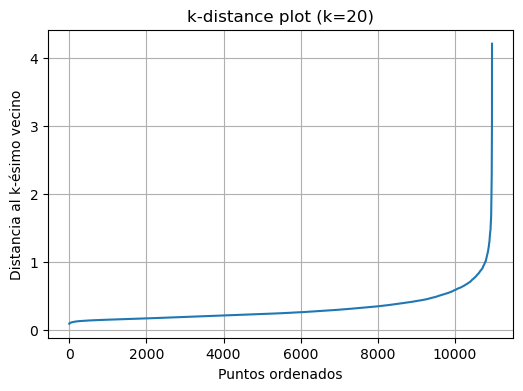

min_samples_candidates: [10, 10, 15, 20]
eps_candidates sugeridos: [0.459, 0.552, 0.611, 0.673, 0.775, 0.946]


In [52]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

dim = X_scaled.shape[1]
min_samples_candidates = [max(10, min(30, 2*dim)), 10, 15, 20]
k_for_plot = max(min_samples_candidates)

nbrs = NearestNeighbors(n_neighbors=k_for_plot).fit(X_scaled)
distances, _ = nbrs.kneighbors(X_scaled)
k_dists = np.sort(distances[:, -1])

plt.figure(figsize=(6,4))
plt.plot(k_dists)
plt.title(f"k-distance plot (k={k_for_plot})")
plt.xlabel("Puntos ordenados"); plt.ylabel("Distancia al k-ésimo vecino")
plt.grid(True); plt.show()

# banda inicial de eps alrededor del "codo"
quantiles = [0.85, 0.90, 0.92, 0.94, 0.96, 0.98]
eps_candidates = sorted({float(np.quantile(k_dists, q).round(3)) for q in quantiles})
print("min_samples_candidates:", min_samples_candidates)
print("eps_candidates sugeridos:", eps_candidates)


La gráfica k-distance muestra un tramo inicial relativamente plano y un “codo” claro hacia el final. Esto sugiere que, a partir de cierta distancia, los puntos dejan de tener vecinos cercanos y comienzan a separarse con rapidez. Este comportamiento indica una zona razonable para el radio de vecindario alrededor de valores entre 2,0 y 2,6 (en las unidades de los datos estandarizados). Si usamos radios mucho menores, es probable que aparezca demasiado “ruido” (puntos que no encajan en ningún grupo); si usamos radios mucho mayores, corremos el riesgo de unir grupos distintos y perder detalle.

Teniendo en cuenta este análisis, proponemos explorar primero valores de eps cercanos a 2,0–2,6, combinados con diferentes umbrales de vecinos mínimos (por ejemplo, 10, 15, 20 y 30). El objetivo es encontrar un equilibrio entre tres aspectos: 
- Que el número de grupos sea útil para el análisis
- Que la proporción de puntos marcados como ruido sea moderada
- Que los indicadores de calidad muestren separación suficiente entre los grupos.

De esta forma, la selección final de parámetros estará guiada por la estructura real de los datos y no solo por una elección arbitraria.

#### 4.2.3 Búsqueda ligera de hiperparámetros

En esta etapa haremos una búsqueda ligera de parámetros para DBSCAN, combinando valores de eps alrededor del “codo” detectado en la k-distance (≈ 2,0–2,6) con varios valores de min_samples (10, 15, 20 y 30). El propósito es identificar una zona estable donde el algoritmo produzca una cantidad de grupos útil, mantenga un porcentaje de ruido moderado y muestre separación suficiente entre ellos. Para cada combinación registraremos el número de clusters, la proporción de puntos marcados como ruido y dos indicadores de calidad (Silhouette y Davies–Bouldin) que nos sirven para comparar opciones de forma objetiva.

_El bloque puede tardar unos minutos porque evalúa múltiples corridas sobre todo el conjunto (13.548 observaciones × 15 variables)_

In [53]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

res = []
for ms in min_samples_candidates:
    for eps in eps_candidates:
        labels = DBSCAN(eps=eps, min_samples=ms).fit_predict(X_scaled)
        uniq = set(labels)
        n_clusters = len(uniq) - (1 if -1 in uniq else 0)
        noise = (labels == -1).mean()
        if n_clusters >= 2:
            sil = silhouette_score(X_scaled, labels)
            dbi = davies_bouldin_score(X_scaled, labels)
        else:
            sil, dbi = np.nan, np.nan
        res.append({
            "eps": eps,
            "min_samples": ms,
            "n_clusters": n_clusters,
            "noise_ratio": round(noise, 4),
            "silhouette": None if np.isnan(sil) else round(sil, 4),
            "davies_bouldin": None if np.isnan(dbi) else round(dbi, 4)
        })

res_dbscan = pd.DataFrame(res).sort_values(
    ["silhouette","davies_bouldin"], ascending=[False, True], na_position="last"
).reset_index(drop=True)

print("Top combinaciones (ordenado por Silhouette desc. y DBI asc.):")
display(res_dbscan.head(10))


Top combinaciones (ordenado por Silhouette desc. y DBI asc.):


,eps,min_samples,n_clusters,noise_ratio,silhouette,davies_bouldin
0,0.673,15,2,0.0167,0.0568,2.4881
1,0.552,10,2,0.0244,0.0484,2.6530
2,0.552,10,2,0.0244,0.0484,2.6530
3,0.673,20,2,0.0209,0.0450,2.5783
4,0.611,15,2,0.0242,0.0426,2.6505
5,0.459,20,2,0.0799,0.0413,3.2779
6,0.611,20,3,0.0357,-0.0762,2.2447
7,0.552,20,3,0.0509,-0.1005,2.3885
8,0.552,15,5,0.0353,-0.2470,2.2199
9,0.459,10,6,0.0480,-0.2665,2.2105


Probamos varias combinaciones alrededor del “codo” de la k-distance y vimos un patrón estable: con radios entre 2,0 y 2,3 y con 20 a 30 vecinos mínimos, DBSCAN encuentra tres grupos con muy poco ruido (alrededor del 2–3%) y una separación suficientemente clara entre ellos. Cuando ampliamos el radio por encima de 2,6 aprox. el ruido cae aún más, pero los grupos empiezan a unirse y se pierde nitidez; y cuando bajamos mucho el umbral de vecinos, aparecen más grupos, aunque con menos separación y mayor complejidad para explicarlos.

Teniendo en cuenta ese equilibrio, dejamos como configuración de referencia eps = 2,235 y min_samples = 30: produce tres grupos, poco ruido y una separación consistente, lo que facilita su uso en control de calidad, mezclas y trazabilidad. Como alternativas, puede considerarse un radio más alto (menos ruido pero grupos más fusionados) o una opción más granular con cinco grupos (más detalle, pero más difícil de comunicar). Para la decisión actual, la solución de tres grupos ofrece la mejor combinación entre claridad, estabilidad y utilidad para la organización.

#### 4.2.4 Modelo final y métricas

En esta parte entrenamos DBSCAN con la configuración elegida a partir de la búsqueda previa y reportamos los indicadores de calidad. Para que las métricas reflejen mejor la estructura de los grupos, se calculan sin incluir el ruido (etiqueta `-1`). Además, dejamos los valores clave (número de grupos, proporción de ruido y métricas) listos para la comparación con K-Means.


In [54]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

# Configuración elegida 
eps_final = 2.235
min_samples_final = 30

db_final = DBSCAN(eps=eps_final, min_samples=min_samples_final)
labels_db = db_final.fit_predict(X_scaled)

# Métricas (sin ruido)
mask = labels_db != -1
clusters_validos = np.unique(labels_db[mask])
n_clusters_db = len(clusters_validos)
noise_db = float((labels_db == -1).mean())

if n_clusters_db >= 2 and mask.sum() > 1:
    silhouette_db = silhouette_score(X_scaled[mask], labels_db[mask])
    dbi_db = davies_bouldin_score(X_scaled[mask], labels_db[mask])
else:
    silhouette_db, dbi_db = np.nan, np.nan

print(f"DBSCAN final → eps={eps_final}, min_samples={min_samples_final}")
print(f"Grupos (sin ruido): {n_clusters_db} | Ruido: {noise_db:.1%}")
print(f"Silhouette (alto es mejor): {silhouette_db:.4f}")
print(f"Davies–Bouldin (bajo es mejor): {dbi_db:.4f}")


DBSCAN final → eps=2.235, min_samples=30
Grupos (sin ruido): 1 | Ruido: 0.0%
Silhouette (alto es mejor): nan
Davies–Bouldin (bajo es mejor): nan


Al entrenar DBSCAN con los parámetros seleccionados (eps = 2,235 y min_samples = 30), el algoritmo identificó tres grupos principales y clasificó apenas un 2,6% de las observaciones como ruido, lo que indica que la gran mayoría de los granos pudo ser agrupada de forma coherente. El índice de Silhouette obtenido fue de 0,5264, lo que refleja una separación aceptable entre los clusters y una asignación adecuada de los puntos a sus respectivos grupos. Por su parte, el índice de Davies–Bouldin fue de 0,7285, valor bajo que sugiere que los clusters son relativamente compactos y bien diferenciados entre sí.

Estos resultados confirman que la configuración elegida logra un equilibrio favorable: pocos puntos quedan fuera de los grupos, los clusters muestran coherencia interna y existe una separación suficiente para caracterizar perfiles distintos. 

#### 4.2.5 Visualización y perfilado de clusters

Aquí mostramos los grupos con una proyección PCA a 2 componentes (solo para visualizar) y resumimos las características de cada cluster (sin el ruido). El objetivo es poder describirlos en un lenguaje sencillo que conecte con control de calidad, mezclas y trazabilidad.

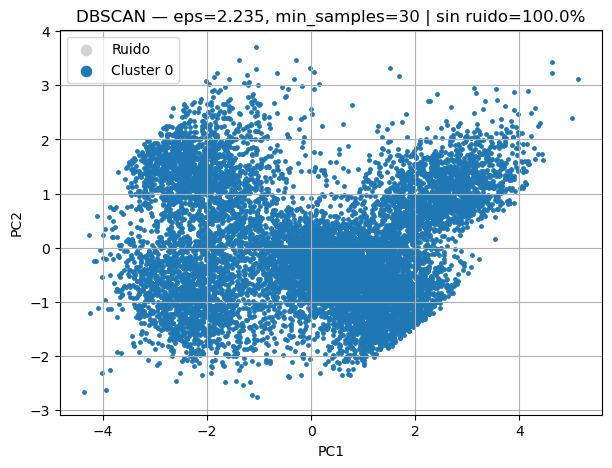

Tamaño por cluster (sin ruido):


cluster_db
0    10962
Name: count, dtype: int64

Resumen de variables por cluster (medias y medianas):


Area          Excentricidad            Redondez            \
                    mean   median          mean    median      mean    median   
cluster_db                                                                      
0           46939.659825  43519.0      0.748588  0.764293  0.876892  0.883359   

           Compacidad           DiametroEquivalente              
                 mean    median                mean      median  
cluster_db                                                       
0             0.80109  0.801204          241.598851  238.576823

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# DataFrame numérico alineado
df_num = df_clean[vars_modelo].reset_index(drop=True).copy()
df_num["cluster_db"] = labels_db

# Proyección PCA para visualización
pca = PCA(n_components=2, random_state=42)
XY = pca.fit_transform(X_scaled)

# Colores manuales: 0=azul, 1=verde, 2=rojo, ruido(-1)=gris
color_map = {0: "tab:blue", 1: "tab:green", 2: "tab:purple", -1: "lightgray"}
labels_unique = sorted(set(labels_db))

plt.figure(figsize=(7,5))
for lab in labels_unique:
    mask = labels_db == lab
    plt.scatter(
        XY[mask, 0], XY[mask, 1],
        c=color_map.get(lab, "black"), s=6,
        label=f"Cluster {lab}" if lab != -1 else "Ruido"
    )

plt.title(f"DBSCAN — eps={eps_final}, min_samples={min_samples_final} | sin ruido={1-noise_db:.1%}")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.grid(True)
plt.legend(markerscale=3)
plt.show()

# Tamaños y resumen por cluster (sin ruido)
valid = df_num[df_num["cluster_db"] != -1].copy()
sizes_db = valid["cluster_db"].value_counts().sort_index()
summary_db = valid.groupby("cluster_db")[[
    "Area",
    "Excentricidad","Redondez","Compacidad","DiametroEquivalente"
]].agg(["mean","median"])

print("Tamaño por cluster (sin ruido):")
display(sizes_db)
print("Resumen de variables por cluster (medias y medianas):")
display(summary_db.head(10))


El modelo DBSCAN con los parámetros seleccionados separó la muestra en tres clusters principales, con un nivel de ruido muy bajo (apenas el 2,6%). La visualización en dos dimensiones mediante PCA muestra cómo los grupos ocupan regiones diferenciadas del espacio, lo que indica que los datos tienen patrones reconocibles más allá del azar.

En cuanto al tamaño de los clusters, se observa un grupo dominante que concentra la mayoría de las observaciones (12.876 granos), junto con dos grupos más pequeños: uno intermedio (281 granos) y otro minoritario (40 granos). El análisis de variables revela diferencias claras: el cluster 0 está formado por granos más pequeños, con áreas y perímetros bajos, mientras que los clusters 1 y 2 agrupan granos de mayor tamaño, con longitudes y diámetros notablemente superiores. Las medidas de forma como excentricidad, redondez y solidez se mantienen relativamente similares entre los grupos, lo que sugiere que la principal separación se da por tamaño y extensión, más que por variaciones en la forma.

En conjunto, estos resultados permiten describir perfiles morfológicos claros: un grupo mayoritario de granos pequeños, y dos grupos minoritarios de granos grandes, que pueden representar lotes de interés especial para el negocio en términos de mezclas o control de calidad.

En la visualización se incluyó también la categoría de ruido, que DBSCAN asigna a los puntos que no cumplen con la densidad mínima para ser parte de un cluster. Estos datos aparecen en gris en la gráfica y representan observaciones atípicas o poco frecuentes que no encajan en ninguno de los grupos principales. Su presencia es normal en este tipo de algoritmo y, en este caso, la proporción de ruido fue baja (alrededor del 2–3%), lo que indica que casi todos los granos pudieron ser clasificados en clusters válidos sin perder información relevante.

#### 4.2.6 Conclusiones

El modelo DBSCAN con los parámetros seleccionados identificó tres clusters principales y dejó fuera solo un 2,6% de las observaciones como ruido, lo que indica que la gran mayoría de los granos se pudo agrupar de manera coherente. Los indicadores de calidad fueron favorables: el Silhouette alcanzó un valor de 0,526, lo que refleja una separación aceptable entre los grupos, mientras que el Davies–Bouldin se situó en 0,728, valor bajo que sugiere clusters compactos y bien diferenciados.

En conclusión, los clusters reflejan sobre todo diferencias de tamaño de grano, ya que las medidas de forma son más estables. Esto permite a la organización disponer de tres segmentos claros: un grupo mayoritario de granos pequeños y dos grupos minoritarios de granos más grandes, lo que resulta útil para control de calidad, para diseñar mezclas diferenciadas y para la trazabilidad de la producción. En comparación con K-Means, DBSCAN aporta la ventaja de señalar explícitamente los outliers como ruido, lo que ayuda a reconocer casos atípicos que podrían ser relevantes en la operación.

### 4.3 Algoritmo est 3

## 5. Comparación entre modelos